# Deep cortical reinforcement learning: Policy gradients + Q-learning + GAN


In this notebook, we'll build a neural network that can learn to play games through reinforcement learning. More specifically, we'll use Q-learning to train an agent to play a game called [Cart-Pole](https://gym.openai.com/envs/CartPole-v0). In this game, a freely swinging pole is attached to a cart. The cart can move to the left and right, and the goal is to keep the pole upright as long as possible.

![Cart-Pole](assets/cart-pole.jpg)

We can simulate this game using [OpenAI Gym](https://gym.openai.com/). First, let's check out how OpenAI Gym works. Then, we'll get into training an agent to play the Cart-Pole game.

In [1]:
# In this one we should define and detect GPUs for tensorflow
# GPUs or CPU
import tensorflow as tf

# Check TensorFlow Version
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.7.1
Default GPU Device: 


>**Note:** Make sure you have OpenAI Gym cloned into the same directory with this notebook. I've included `gym` as a submodule, so you can run `git submodule --init --recursive` to pull the contents into the `gym` repo.

##### >**Note:** Make sure you have OpenAI Gym cloned. Then run this command `pip install -e gym/[all]`.

In [2]:
import gym

## Create the Cart-Pole game environment
env = gym.make('CartPole-v0')
env = gym.make('CartPole-v1')
# env = gym.make('Acrobot-v1')
# env = gym.make('MountainCar-v0')
# env = gym.make('MountainCarContinuous-v0')
# env = gym.make('Pendulum-v0')
# env = gym.make('Blackjack-v0')
# env = gym.make('FrozenLake-v0')
# env = gym.make('AirRaid-ram-v0')
# env = gym.make('AirRaid-v0')
# env = gym.make('BipedalWalker-v2')
# env = gym.make('Copy-v0')
# env = gym.make('CarRacing-v0')
# env = gym.make('Ant-v2') #mujoco
# env = gym.make('FetchPickAndPlace-v1') # mujoco required!

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


/home/arasdar/anaconda3/envs/env/lib/python3.6/site-packages/gym/__init__.py:22: UserWarning: DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.
  warnings.warn('DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.')


We interact with the simulation through `env`. To show the simulation running, you can use `env.render()` to render one frame. Passing in an action as an integer to `env.step` will generate the next step in the simulation.  You can see how many actions are possible from `env.action_space` and to get a random action you can use `env.action_space.sample()`. This is general to all Gym games. In the Cart-Pole game, there are two possible actions, moving the cart left or right. So there are two actions we can take, encoded as 0 and 1.

Run the code below to watch the simulation run.

In [3]:
env.reset()
batch = []
for _ in range(1111):
    #env.render()
    action = env.action_space.sample()
    state, reward, done, info = env.step(action) # take a random action
    batch.append([action, state, reward, done, info])
    #print('state, action, reward, done, info:', state, action, reward, done, info)
    if done:
        env.reset()

To shut the window showing the simulation, use `env.close()`.

In [4]:
# env.close()

If you ran the simulation above, we can look at the rewards:

In [5]:
batch[0], 
batch[0][1].shape, state.shape

((4,), (4,))

In [6]:
import numpy as np
actions = np.array([each[0] for each in batch])
states = np.array([each[1] for each in batch])
rewards = np.array([each[2] for each in batch])
dones = np.array([each[3] for each in batch])
infos = np.array([each[4] for each in batch])

In [7]:
# print(rewards[-20:])
print('shapes:', np.array(rewards).shape, np.array(states).shape, np.array(actions).shape, np.array(dones).shape)
print('dtypes:', np.array(rewards).dtype, np.array(states).dtype, np.array(actions).dtype, np.array(dones).dtype)
print('states:', np.max(np.array(states)), np.min(np.array(states)))
print('actions:', np.max(np.array(actions)), np.min(np.array(actions)))
# print((np.max(np.array(actions)) - np.min(np.array(actions)))+1)
print('rewards:', np.max(np.array(rewards)), np.min(np.array(rewards)))

shapes: (1111,) (1111, 4) (1111,) (1111,)
dtypes: float64 float64 int64 bool
states: 2.269951390800136 -2.6495541147104222
actions: 1 0
rewards: 1.0 1.0


In [8]:
actions[:10]

array([0, 1, 1, 0, 1, 1, 1, 1, 1, 1])

In [9]:
rewards[:10]

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [10]:
# import numpy as np
def sigmoid(x, derivative=False):
  return x*(1-x) if derivative else 1/(1+np.exp(-x))

In [11]:
sigmoid(np.max(np.array(rewards))), sigmoid(np.min(np.array(rewards)))

(0.7310585786300049, 0.7310585786300049)

In [12]:
print('rewards:', np.max(np.array(rewards))/100, np.min(np.array(rewards))/100)

rewards: 0.01 0.01


The game resets after the pole has fallen past a certain angle. For each frame while the simulation is running, it returns a reward of 1.0. The longer the game runs, the more reward we get. Then, our network's goal is to maximize the reward by keeping the pole vertical. It will do this by moving the cart to the left and the right.

## Q-Network

We train our Q-learning agent using the Bellman Equation:

$$
Q(s, a) = r + \gamma \max{Q(s', a')}
$$

where $s$ is a state, $a$ is an action, and $s'$ is the next state from state $s$ and action $a$.

Before we used this equation to learn values for a Q-_table_. However, for this game there are a huge number of states available. The state has four values: the position and velocity of the cart, and the position and velocity of the pole. These are all real-valued numbers, so ignoring floating point precisions, you practically have infinite states. Instead of using a table then, we'll replace it with a neural network that will approximate the Q-table lookup function.

<img src="assets/deep-q-learning.png" width=450px>

Now, our Q value, $Q(s, a)$ is calculated by passing in a state to the network. The output will be Q-values for each available action, with fully connected hidden layers.

<img src="assets/q-network.png" width=550px>


As I showed before, we can define our targets for training as $\hat{Q}(s,a) = r + \gamma \max{Q(s', a')}$. Then we update the weights by minimizing $(\hat{Q}(s,a) - Q(s,a))^2$. 

For this Cart-Pole game, we have four inputs, one for each value in the state, and two outputs, one for each action. To get $\hat{Q}$, we'll first choose an action, then simulate the game using that action. This will get us the next state, $s'$, and the reward. With that, we can calculate $\hat{Q}$ then pass it back into the $Q$ network to run the optimizer and update the weights.

Below is my implementation of the Q-network. I used two fully connected layers with ReLU activations. Two seems to be good enough, three might be better. Feel free to try it out.

In [13]:
# Data of the model
def model_input(state_size):
    states = tf.placeholder(tf.float32, [None, state_size], name='states')
    actions = tf.placeholder(tf.int32, [None], name='actions')
    targetQs = tf.placeholder(tf.float32, [None], name='targetQs')
    reward = tf.placeholder(tf.float32, [], name='reward')
    return states, actions, targetQs, reward

In [14]:
# How to use batch-norm
#   x_norm = tf.layers.batch_normalization(x, training=training)

#   # ...

#   update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
#   with tf.control_dependencies(update_ops):
#     train_op = optimizer.minimize(loss)

In [15]:
# training: Either a Python boolean, or a TensorFlow boolean scalar tensor (e.g. a placeholder). 
# Whether to return the output in: 
# training mode (normalized with statistics of the current batch) or 
# inference mode (normalized with moving statistics). 
# NOTE: make sure to set this parameter correctly, or else your training/inference will not work properly.

In [16]:
# Generator/Controller: Generating/prediting the actions
def generator(states, action_size, hidden_size, reuse=False, alpha=0.1, training=False):
    with tf.variable_scope('generator', reuse=reuse):
        # First fully connected layer
        h1 = tf.layers.dense(inputs=states, units=hidden_size)
        bn1 = tf.layers.batch_normalization(h1, training=training)        
        nl1 = tf.maximum(alpha * bn1, bn1)
        
        # Second fully connected layer
        h2 = tf.layers.dense(inputs=nl1, units=hidden_size)
        bn2 = tf.layers.batch_normalization(h2, training=training)        
        nl2 = tf.maximum(alpha * bn2, bn2)
        
        # Output layer
        logits = tf.layers.dense(inputs=nl2, units=action_size)        
        #predictions = tf.nn.softmax(logits)

        # return actions logits
        return logits

In [17]:
# Discriminator/Dopamine: Reward function/planner/naviator/advisor/supervisor/cortical columns
def discriminator(states, actions, hidden_size, reuse=False, alpha=0.1, training=False):
    with tf.variable_scope('discriminator', reuse=reuse):
        # Fusion/merge states and actions/ SA/ SM
        x_fused = tf.concat(axis=1, values=[states, actions])
        
        # First fully connected layer
        h1 = tf.layers.dense(inputs=x_fused, units=hidden_size)
        bn1 = tf.layers.batch_normalization(h1, training=training)        
        nl1 = tf.maximum(alpha * bn1, bn1)
        
        # Second fully connected layer
        h2 = tf.layers.dense(inputs=nl1, units=hidden_size)
        bn2 = tf.layers.batch_normalization(h2, training=training)        
        nl2 = tf.maximum(alpha * bn2, bn2)
        
        # Output layer
        logits = tf.layers.dense(inputs=nl2, units=1)        
        #predictions = tf.nn.softmax(logits)

        # return rewards logits
        return logits

In [19]:
def model_loss(action_size, hidden_size, states, actions, targetQs, reward):
    # G
    actions_logits = generator(states=states, hidden_size=hidden_size, action_size=action_size)
    actions_labels = tf.one_hot(indices=actions, depth=action_size, dtype=actions_logits.dtype)
    neg_log_prob_actions = tf.nn.softmax_cross_entropy_with_logits_v2(logits=actions_logits, 
                                                                      labels=actions_labels)
    rewards = reward * tf.ones_like(targetQs)
    #Qs_labels = targetQs[1:]
    Qs_labels = rewards[:-1] + (0.99*targetQs[1:])
    Qs_labels = tf.concat(axis=0, values=[Qs_labels, tf.zeros([1])])
    g_loss = tf.reduce_mean(neg_log_prob_actions * Qs_labels)
    #g_loss = tf.reduce_mean(neg_log_prob_actions[:-1] * Qs_labels)
    
    # D
    Qs_logits = discriminator(actions=actions_logits, hidden_size=hidden_size, states=states)
    d_lossR = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=tf.reshape(Qs_logits, [-1]),
                                                                     labels=rewards))
    d_lossQ = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=tf.reshape(Qs_logits, [-1]),
                                                                     labels=tf.nn.sigmoid(Qs_labels)))
    # d_lossQ = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=tf.reshape(Qs_logits[:-1], [-1]),
    #                                                                  labels=tf.nn.sigmoid(Qs_labels)))
    d_loss = d_lossR #+ d_lossQ

    return actions_logits, Qs_logits, g_loss, d_loss, d_lossR, d_lossQ

In [20]:
# Optimizating/training/learning G & D
def model_opt(g_loss, d_loss, learning_rate):
    """
    Get optimization operations in order
    :param g_loss: Generator loss Tensor for action prediction
    :param d_loss: Discriminator loss Tensor for reward prediction for generated/prob/logits action
    :param learning_rate: Learning Rate Placeholder
    :return: A tuple of (qfunction training, generator training, discriminator training)
    """
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)): # Required for batchnorm (BN)
        g_opt = tf.train.AdamOptimizer(learning_rate).minimize(g_loss, var_list=g_vars)
        d_opt = tf.train.AdamOptimizer(learning_rate).minimize(d_loss, var_list=d_vars)

    return g_opt, d_opt

In [21]:
class Model:
    def __init__(self, state_size, action_size, hidden_size, learning_rate):

        # Data of the Model: make the data available inside the framework
        self.states, self.actions, self.targetQs, self.reward = model_input(state_size=state_size)

        # Create the Model: calculating the loss and forwad pass
        self.actions_logits, self.Qs_logits, self.g_loss, self.d_loss, self.d_lossR, self.d_lossQ = model_loss(
            action_size=action_size, hidden_size=hidden_size, # model init parameters
            states=self.states, actions=self.actions, # model input
            targetQs=self.targetQs, reward=self.reward) # model input
        
        # Update the model: backward pass and backprop
        self.g_opt, self.d_opt = model_opt(g_loss=self.g_loss, d_loss=self.d_loss, learning_rate=learning_rate)

## Hyperparameters

One of the more difficult aspects of reinforcememt learning are the large number of hyperparameters. Not only are we tuning the network, but we're tuning the simulation.

In [22]:
print('state size:{}'.format(states.shape), 
      'actions:{}'.format(actions.shape)) 
print('action size:{}'.format(np.max(actions) - np.min(actions)+1))

state size:(1111, 4) actions:(1111,)
action size:2


In [23]:
# Training parameters
# Network parameters
state_size = 4               # number of units for the input state/observation -- simulation
action_size = 2              # number of units for the output actions -- simulation
hidden_size = 64             # number of units in each Q-network hidden layer -- simulation
learning_rate = 0.001          # learning rate for adam

In [24]:
# Reset/init the graph/session
graph = tf.reset_default_graph()

# Init the model
model = Model(action_size=action_size, hidden_size=hidden_size, state_size=state_size, learning_rate=learning_rate)

## Training the model

Below we'll train our agent. If you want to watch it train, uncomment the `env.render()` line. This is slow because it's rendering the frames slower than the network can train. But, it's cool to watch the agent get better at the game.

In [25]:
# import gym

# ## Create the Cart-Pole game environment
# env = gym.make('CartPole-v0')
# env = gym.make('CartPole-v1')
# env = gym.make('Acrobot-v1')
# # env = gym.make('MountainCar-v0')
# # env = gym.make('Pendulum-v0')
# # env = gym.make('Blackjack-v0')
# # env = gym.make('FrozenLake-v0')
# # env = gym.make('AirRaid-ram-v0')
# # env = gym.make('AirRaid-v0')
# # env = gym.make('BipedalWalker-v2')
# # env = gym.make('Copy-v0')
# # env = gym.make('CarRacing-v0')
# # env = gym.make('Ant-v2') #mujoco
# # env = gym.make('FetchPickAndPlace-v1') # mujoco required!

In [30]:
from collections import deque
episodes_total_reward = deque(maxlen=100) # 100 episodes average/running average/running mean/window
saver = tf.train.Saver()
rewards_list, g_loss_list, d_loss_list = [], [], []
rates_list, d_lossR_list, d_lossQ_list = [], [], []

# TF session for training
with tf.Session(graph=graph) as sess:
    sess.run(tf.global_variables_initializer())
    #saver.restore(sess, 'checkpoints/model.ckpt')    
    #saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    
    # Training episodes/epochs
    for ep in range(111111):
        batch = [] # every data batch
        total_reward = 0
        state = env.reset() # env first state

        # Training steps/batches
        while True:
            action_logits, Q_logits = sess.run(fetches=[model.actions_logits, model.Qs_logits], 
                                               feed_dict={model.states: np.reshape(state, [1, -1])})
            action = np.argmax(action_logits)
            batch.append([state, action, Q_logits])
            state, reward, done, _ = env.step(action)
            total_reward += reward
            if done is True: # episode ended success/failure
                episodes_total_reward.append(total_reward) # stopping criteria
                rate = total_reward/ 500 # success is 500 points: 0-1
                break

        # Training using batches
        #batch = memory.buffer
        states = np.array([each[0] for each in batch])
        actions = np.array([each[1] for each in batch])
        targetQs = np.array([each[2] for each in batch])
        g_loss, d_loss, d_lossR, d_lossQ, _, _ = sess.run([model.g_loss, model.d_loss, 
                                                           model.d_lossR, model.d_lossQ, 
                                                           model.g_opt, model.d_opt],
                                                          feed_dict = {model.states: states, 
                                                                       model.actions: actions,
                                                                       model.reward: rate,
                                                                       model.targetQs: targetQs.reshape([-1])})
        # Average 100 episode total reward
        # Print out
        print('Episode:{}'.format(ep),
              'meanR:{:.4f}'.format(np.mean(episodes_total_reward)),
              'rate:{:.4f}'.format(rate),
              'gloss:{:.4f}'.format(g_loss),
              'dloss:{:.4f}'.format(d_loss),
              'dlossR:{:.4f}'.format(d_lossR),
              'dlossQ:{:.4f}'.format(d_lossQ))
        # Ploting out
        rewards_list.append([ep, np.mean(episodes_total_reward)])
        rates_list.append([ep, rate])
        g_loss_list.append([ep, g_loss])
        d_loss_list.append([ep, d_loss])
        d_lossR_list.append([ep, d_lossR])
        d_lossQ_list.append([ep, d_lossQ])
        # Break episode/epoch loop
        if np.mean(episodes_total_reward) >= 500:
            break
            
    # At the end of all training episodes/epochs
    saver.save(sess, 'checkpoints/modelR.ckpt')

Episode:0 meanR:10.0000 rate:0.0200 gloss:0.1528 dloss:0.8034 dlossR:0.8034 dlossQ:0.6872
Episode:1 meanR:9.0000 rate:0.0160 gloss:0.0851 dloss:0.7545 dlossR:0.7545 dlossQ:0.6913
Episode:2 meanR:9.3333 rate:0.0200 gloss:0.0534 dloss:0.7287 dlossR:0.7287 dlossQ:0.6922
Episode:3 meanR:9.2500 rate:0.0180 gloss:0.0097 dloss:0.6921 dlossR:0.6921 dlossQ:0.6931
Episode:4 meanR:9.6000 rate:0.0220 gloss:-0.0265 dloss:0.6576 dlossR:0.6576 dlossQ:0.6929
Episode:5 meanR:9.6667 rate:0.0200 gloss:-0.0603 dloss:0.6261 dlossR:0.6261 dlossQ:0.6917
Episode:6 meanR:9.7143 rate:0.0200 gloss:-0.0940 dloss:0.5952 dlossR:0.5952 dlossQ:0.6893
Episode:7 meanR:9.5000 rate:0.0160 gloss:-0.1129 dloss:0.5839 dlossR:0.5839 dlossQ:0.6885
Episode:8 meanR:9.4444 rate:0.0180 gloss:-0.1489 dloss:0.5524 dlossR:0.5524 dlossQ:0.6841
Episode:9 meanR:9.5000 rate:0.0200 gloss:-0.1928 dloss:0.5211 dlossR:0.5211 dlossQ:0.6781
Episode:10 meanR:9.5455 rate:0.0200 gloss:-0.2261 dloss:0.5052 dlossR:0.5052 dlossQ:0.6743
Episode:11 m

Episode:92 meanR:22.7097 rate:0.0660 gloss:-1.7553 dloss:0.2436 dlossR:0.2436 dlossQ:0.2800
Episode:93 meanR:23.0319 rate:0.1060 gloss:-1.7888 dloss:0.3555 dlossR:0.3555 dlossQ:0.2654
Episode:94 meanR:23.4632 rate:0.1280 gloss:-1.7582 dloss:0.4144 dlossR:0.4144 dlossQ:0.2698
Episode:95 meanR:25.1042 rate:0.3620 gloss:-1.7830 dloss:1.1334 dlossR:1.1334 dlossQ:0.2625
Episode:96 meanR:25.2887 rate:0.0860 gloss:-1.6964 dloss:0.2963 dlossR:0.2963 dlossQ:0.2899
Episode:97 meanR:25.3776 rate:0.0680 gloss:-1.6845 dloss:0.2487 dlossR:0.2487 dlossQ:0.2956
Episode:98 meanR:25.4949 rate:0.0740 gloss:-1.6769 dloss:0.2643 dlossR:0.2643 dlossQ:0.2969
Episode:99 meanR:25.6900 rate:0.0900 gloss:-1.6685 dloss:0.3058 dlossR:0.3058 dlossQ:0.2962
Episode:100 meanR:25.9300 rate:0.0680 gloss:-1.6509 dloss:0.2487 dlossR:0.2487 dlossQ:0.3058
Episode:101 meanR:26.1600 rate:0.0620 gloss:-1.6542 dloss:0.2333 dlossR:0.2333 dlossQ:0.3055
Episode:102 meanR:26.4600 rate:0.0800 gloss:-1.6749 dloss:0.2798 dlossR:0.2798

Episode:181 meanR:36.5100 rate:0.0340 gloss:-1.5451 dloss:0.1685 dlossR:0.1685 dlossQ:0.3573
Episode:182 meanR:36.2900 rate:0.0300 gloss:-1.5934 dloss:0.1549 dlossR:0.1549 dlossQ:0.3515
Episode:183 meanR:36.1700 rate:0.0220 gloss:-1.6260 dloss:0.1304 dlossR:0.1304 dlossQ:0.3613
Episode:184 meanR:36.2100 rate:0.0320 gloss:-1.7040 dloss:0.1545 dlossR:0.1545 dlossQ:0.3313
Episode:185 meanR:36.2400 rate:0.0220 gloss:-1.7011 dloss:0.1263 dlossR:0.1263 dlossQ:0.3440
Episode:186 meanR:36.2800 rate:0.0280 gloss:-1.7544 dloss:0.1411 dlossR:0.1411 dlossQ:0.3303
Episode:187 meanR:36.2600 rate:0.0300 gloss:-1.7662 dloss:0.1464 dlossR:0.1464 dlossQ:0.3156
Episode:188 meanR:36.1800 rate:0.0300 gloss:-1.7968 dloss:0.1458 dlossR:0.1458 dlossQ:0.3126
Episode:189 meanR:36.1200 rate:0.0660 gloss:-1.9865 dloss:0.2537 dlossR:0.2537 dlossQ:0.2719
Episode:190 meanR:36.1700 rate:0.0640 gloss:-1.8518 dloss:0.2448 dlossR:0.2448 dlossQ:0.3029
Episode:191 meanR:36.3900 rate:0.1240 gloss:-1.7113 dloss:0.4015 dloss

Episode:270 meanR:34.2400 rate:0.0460 gloss:-1.6224 dloss:0.1937 dlossR:0.1937 dlossQ:0.3340
Episode:271 meanR:34.1600 rate:0.0720 gloss:-1.6788 dloss:0.2597 dlossR:0.2597 dlossQ:0.3115
Episode:272 meanR:35.6300 rate:0.3440 gloss:-1.6678 dloss:1.0219 dlossR:1.0219 dlossQ:0.2989
Episode:273 meanR:36.3200 rate:0.2000 gloss:-1.6220 dloss:0.5910 dlossR:0.5910 dlossQ:0.3103
Episode:274 meanR:37.1700 rate:0.2260 gloss:-1.5953 dloss:0.6560 dlossR:0.6560 dlossQ:0.3176
Episode:275 meanR:37.5800 rate:0.1280 gloss:-1.8606 dloss:0.4256 dlossR:0.4256 dlossQ:0.2589
Episode:276 meanR:37.7400 rate:0.0720 gloss:-2.0440 dloss:0.2723 dlossR:0.2723 dlossQ:0.2468
Episode:277 meanR:37.6400 rate:0.0220 gloss:-2.1732 dloss:0.1116 dlossR:0.1116 dlossQ:0.3179
Episode:278 meanR:37.5500 rate:0.0220 gloss:-2.0030 dloss:0.1141 dlossR:0.1141 dlossQ:0.3079
Episode:279 meanR:37.5300 rate:0.0280 gloss:-2.0371 dloss:0.1334 dlossR:0.1334 dlossQ:0.2935
Episode:280 meanR:37.5700 rate:0.0500 gloss:-1.8931 dloss:0.2056 dloss

Episode:367 meanR:50.1600 rate:0.0240 gloss:-1.5920 dloss:0.1419 dlossR:0.1419 dlossQ:0.3711
Episode:368 meanR:50.0800 rate:0.0380 gloss:-1.5620 dloss:0.1794 dlossR:0.1794 dlossQ:0.3494
Episode:369 meanR:49.9600 rate:0.0280 gloss:-1.5854 dloss:0.1523 dlossR:0.1523 dlossQ:0.3683
Episode:370 meanR:49.8900 rate:0.0320 gloss:-1.6108 dloss:0.1610 dlossR:0.1610 dlossQ:0.3402
Episode:371 meanR:49.6800 rate:0.0300 gloss:-1.5712 dloss:0.1578 dlossR:0.1578 dlossQ:0.3635
Episode:372 meanR:48.5100 rate:0.1100 gloss:-1.4623 dloss:0.3529 dlossR:0.3529 dlossQ:0.3629
Episode:373 meanR:47.9000 rate:0.0780 gloss:-1.5508 dloss:0.2808 dlossR:0.2808 dlossQ:0.3562
Episode:374 meanR:47.7500 rate:0.1960 gloss:-1.3988 dloss:0.5449 dlossR:0.5449 dlossQ:0.3723
Episode:375 meanR:47.6200 rate:0.1020 gloss:-1.4044 dloss:0.3315 dlossR:0.3315 dlossQ:0.3700
Episode:376 meanR:47.6800 rate:0.0840 gloss:-1.4140 dloss:0.2922 dlossR:0.2922 dlossQ:0.3684
Episode:377 meanR:48.0400 rate:0.0940 gloss:-1.4478 dloss:0.3146 dloss

Episode:463 meanR:32.7700 rate:0.0780 gloss:-1.5213 dloss:0.2791 dlossR:0.2791 dlossQ:0.3640
Episode:464 meanR:33.0500 rate:0.0760 gloss:-1.4770 dloss:0.2732 dlossR:0.2732 dlossQ:0.3631
Episode:465 meanR:33.6400 rate:0.1400 gloss:-1.4055 dloss:0.4143 dlossR:0.4143 dlossQ:0.3691
Episode:466 meanR:34.2600 rate:0.1420 gloss:-1.4048 dloss:0.4189 dlossR:0.4189 dlossQ:0.3711
Episode:467 meanR:35.1300 rate:0.1980 gloss:-1.4472 dloss:0.5549 dlossR:0.5549 dlossQ:0.3565
Episode:468 meanR:36.7900 rate:0.3700 gloss:-1.2594 dloss:0.9248 dlossR:0.9248 dlossQ:0.4152
Episode:469 meanR:37.3700 rate:0.1440 gloss:-1.4713 dloss:0.4286 dlossR:0.4286 dlossQ:0.3526
Episode:470 meanR:38.0000 rate:0.1580 gloss:-1.3239 dloss:0.4484 dlossR:0.4484 dlossQ:0.3919
Episode:471 meanR:39.5100 rate:0.3320 gloss:-1.2116 dloss:0.8158 dlossR:0.8158 dlossQ:0.4289
Episode:472 meanR:39.8600 rate:0.1800 gloss:-1.3650 dloss:0.5013 dlossR:0.5013 dlossQ:0.3827
Episode:473 meanR:40.4200 rate:0.1900 gloss:-1.3266 dloss:0.5190 dloss

Episode:553 meanR:62.7800 rate:0.0840 gloss:-1.2266 dloss:0.2998 dlossR:0.2998 dlossQ:0.4301
Episode:554 meanR:61.8000 rate:0.0540 gloss:-1.2321 dloss:0.2424 dlossR:0.2424 dlossQ:0.4273
Episode:555 meanR:61.6700 rate:0.0420 gloss:-1.2834 dloss:0.2135 dlossR:0.2135 dlossQ:0.4236
Episode:556 meanR:61.3300 rate:0.0520 gloss:-1.3708 dloss:0.2258 dlossR:0.2258 dlossQ:0.3968
Episode:557 meanR:61.3400 rate:0.0420 gloss:-1.3520 dloss:0.2065 dlossR:0.2065 dlossQ:0.4027
Episode:558 meanR:61.4900 rate:0.0480 gloss:-1.4374 dloss:0.2127 dlossR:0.2127 dlossQ:0.3777
Episode:559 meanR:61.6100 rate:0.0440 gloss:-1.3678 dloss:0.2094 dlossR:0.2094 dlossQ:0.4025
Episode:560 meanR:61.5600 rate:0.0540 gloss:-1.3676 dloss:0.2309 dlossR:0.2309 dlossQ:0.3914
Episode:561 meanR:61.6200 rate:0.0380 gloss:-1.3947 dloss:0.1939 dlossR:0.1939 dlossQ:0.3901
Episode:562 meanR:61.5400 rate:0.0540 gloss:-1.4378 dloss:0.2265 dlossR:0.2265 dlossQ:0.3714
Episode:563 meanR:61.5700 rate:0.0840 gloss:-1.3012 dloss:0.2979 dloss

Episode:642 meanR:59.7500 rate:0.0300 gloss:-1.4317 dloss:0.1784 dlossR:0.1784 dlossQ:0.3963
Episode:643 meanR:59.9500 rate:0.2500 gloss:-0.6541 dloss:0.5794 dlossR:0.5794 dlossQ:0.5960
Episode:644 meanR:59.6900 rate:0.0360 gloss:-1.4658 dloss:0.1949 dlossR:0.1949 dlossQ:0.3933
Episode:645 meanR:59.8200 rate:0.0460 gloss:-1.3230 dloss:0.2336 dlossR:0.2336 dlossQ:0.4379
Episode:646 meanR:58.9100 rate:0.2300 gloss:-0.8384 dloss:0.5480 dlossR:0.5480 dlossQ:0.5482
Episode:647 meanR:58.5600 rate:0.1560 gloss:-0.9084 dloss:0.4406 dlossR:0.4406 dlossQ:0.5235
Episode:648 meanR:59.1600 rate:0.1440 gloss:-1.0214 dloss:0.4232 dlossR:0.4232 dlossQ:0.4886
Episode:649 meanR:59.0000 rate:0.0380 gloss:-0.9963 dloss:0.2515 dlossR:0.2515 dlossQ:0.5006
Episode:650 meanR:57.6300 rate:0.0320 gloss:-1.0739 dloss:0.2280 dlossR:0.2280 dlossQ:0.4900
Episode:651 meanR:55.8200 rate:0.0340 gloss:-1.0288 dloss:0.2393 dlossR:0.2393 dlossQ:0.4984
Episode:652 meanR:55.4300 rate:0.0240 gloss:-1.0826 dloss:0.2097 dloss

Episode:733 meanR:49.7300 rate:0.3380 gloss:-0.9941 dloss:0.7654 dlossR:0.7654 dlossQ:0.4990
Episode:734 meanR:50.6100 rate:0.2060 gloss:-1.1258 dloss:0.5298 dlossR:0.5298 dlossQ:0.4524
Episode:735 meanR:51.2700 rate:0.1680 gloss:-1.2142 dloss:0.4616 dlossR:0.4616 dlossQ:0.4259
Episode:736 meanR:51.5500 rate:0.0960 gloss:-1.3222 dloss:0.3197 dlossR:0.3197 dlossQ:0.4000
Episode:737 meanR:50.8600 rate:0.0320 gloss:-1.5797 dloss:0.1669 dlossR:0.1669 dlossQ:0.3759
Episode:738 meanR:50.2900 rate:0.0220 gloss:-1.8077 dloss:0.1274 dlossR:0.1274 dlossQ:0.3604
Episode:739 meanR:49.6800 rate:0.1100 gloss:-1.2394 dloss:0.3486 dlossR:0.3486 dlossQ:0.4220
Episode:740 meanR:52.0900 rate:0.7200 gloss:-0.7833 dloss:1.4944 dlossR:1.4944 dlossQ:0.5993
Episode:741 meanR:52.0700 rate:0.2840 gloss:-1.2522 dloss:0.7181 dlossR:0.7181 dlossQ:0.4192
Episode:742 meanR:53.0800 rate:0.2320 gloss:-1.2574 dloss:0.6022 dlossR:0.6022 dlossQ:0.4164
Episode:743 meanR:52.9600 rate:0.2260 gloss:-1.2767 dloss:0.5934 dloss

Episode:823 meanR:73.4000 rate:0.3920 gloss:-1.0049 dloss:0.8780 dlossR:0.8780 dlossQ:0.5051
Episode:824 meanR:74.2800 rate:0.3400 gloss:-1.0663 dloss:0.7880 dlossR:0.7880 dlossQ:0.4797
Episode:825 meanR:74.4100 rate:0.1780 gloss:-1.1969 dloss:0.4818 dlossR:0.4818 dlossQ:0.4326
Episode:826 meanR:74.8800 rate:0.1120 gloss:-1.1930 dloss:0.3531 dlossR:0.3531 dlossQ:0.4329
Episode:827 meanR:74.9000 rate:0.0560 gloss:-1.2458 dloss:0.2442 dlossR:0.2442 dlossQ:0.4226
Episode:828 meanR:74.0900 rate:0.0640 gloss:-1.2514 dloss:0.2593 dlossR:0.2593 dlossQ:0.4198
Episode:829 meanR:73.7100 rate:0.0440 gloss:-1.2771 dloss:0.2174 dlossR:0.2174 dlossQ:0.4157
Episode:830 meanR:73.4900 rate:0.0400 gloss:-1.2938 dloss:0.2073 dlossR:0.2073 dlossQ:0.4206
Episode:831 meanR:73.3600 rate:0.0500 gloss:-1.3094 dloss:0.2270 dlossR:0.2270 dlossQ:0.4068
Episode:832 meanR:72.9900 rate:0.0340 gloss:-1.3674 dloss:0.1867 dlossR:0.1867 dlossQ:0.3968
Episode:833 meanR:71.4800 rate:0.0360 gloss:-1.4096 dloss:0.1870 dloss

Episode:913 meanR:60.6900 rate:0.0400 gloss:-1.1467 dloss:0.2311 dlossR:0.2311 dlossQ:0.4627
Episode:914 meanR:59.4100 rate:0.0380 gloss:-1.1765 dloss:0.2233 dlossR:0.2233 dlossQ:0.4620
Episode:915 meanR:59.2700 rate:0.0640 gloss:-1.1208 dloss:0.2766 dlossR:0.2766 dlossQ:0.4656
Episode:916 meanR:59.5600 rate:0.0900 gloss:-1.0716 dloss:0.3245 dlossR:0.3245 dlossQ:0.4769
Episode:917 meanR:59.8300 rate:0.0780 gloss:-1.1387 dloss:0.2982 dlossR:0.2982 dlossQ:0.4571
Episode:918 meanR:60.2500 rate:0.1240 gloss:-1.0181 dloss:0.3842 dlossR:0.3842 dlossQ:0.4893
Episode:919 meanR:60.7600 rate:0.1200 gloss:-1.0769 dloss:0.3741 dlossR:0.3741 dlossQ:0.4724
Episode:920 meanR:61.8100 rate:0.2340 gloss:-0.9744 dloss:0.5660 dlossR:0.5660 dlossQ:0.5066
Episode:921 meanR:63.0900 rate:0.2760 gloss:-0.9364 dloss:0.6342 dlossR:0.6342 dlossQ:0.5196
Episode:922 meanR:64.9200 rate:0.3980 gloss:-0.8013 dloss:0.8178 dlossR:0.8178 dlossQ:0.5679
Episode:923 meanR:64.6400 rate:0.3360 gloss:-0.8415 dloss:0.7188 dloss

Episode:1007 meanR:58.5700 rate:0.0300 gloss:-1.2617 dloss:0.1928 dlossR:0.1928 dlossQ:0.4320
Episode:1008 meanR:58.5100 rate:0.0220 gloss:-1.3431 dloss:0.1653 dlossR:0.1653 dlossQ:0.4406
Episode:1009 meanR:58.4000 rate:0.0200 gloss:-2.0955 dloss:0.1343 dlossR:0.1343 dlossQ:0.4362
Episode:1010 meanR:58.7500 rate:0.1060 gloss:-1.1238 dloss:0.3526 dlossR:0.3526 dlossQ:0.4686
Episode:1011 meanR:58.7100 rate:0.0220 gloss:-1.4734 dloss:0.1526 dlossR:0.1526 dlossQ:0.4092
Episode:1012 meanR:58.6100 rate:0.0200 gloss:-1.6334 dloss:0.1365 dlossR:0.1365 dlossQ:0.4022
Episode:1013 meanR:59.1200 rate:0.1420 gloss:-1.1004 dloss:0.4130 dlossR:0.4130 dlossQ:0.4700
Episode:1014 meanR:63.0100 rate:0.8160 gloss:-0.3025 dloss:1.3028 dlossR:1.3028 dlossQ:0.7203
Episode:1015 meanR:65.0700 rate:0.4760 gloss:-0.6603 dloss:0.9067 dlossR:0.9067 dlossQ:0.6098
Episode:1016 meanR:65.3500 rate:0.1460 gloss:-0.9510 dloss:0.4203 dlossR:0.4203 dlossQ:0.5108
Episode:1017 meanR:65.4900 rate:0.1060 gloss:-1.0201 dloss:0

Episode:1095 meanR:85.6700 rate:0.3120 gloss:-0.5115 dloss:0.6338 dlossR:0.6338 dlossQ:0.6480
Episode:1096 meanR:85.8300 rate:0.2020 gloss:-0.7636 dloss:0.5132 dlossR:0.5132 dlossQ:0.5779
Episode:1097 meanR:84.4100 rate:0.1220 gloss:-0.8845 dloss:0.4012 dlossR:0.4012 dlossQ:0.5452
Episode:1098 meanR:84.2900 rate:0.3500 gloss:-0.5440 dloss:0.6847 dlossR:0.6847 dlossQ:0.6417
Episode:1099 meanR:83.6400 rate:0.1920 gloss:-0.8242 dloss:0.4966 dlossR:0.4966 dlossQ:0.5561
Episode:1100 meanR:83.4600 rate:0.0940 gloss:-1.0601 dloss:0.3525 dlossR:0.3525 dlossQ:0.5045
Episode:1101 meanR:84.0800 rate:0.2220 gloss:-0.6647 dloss:0.5412 dlossR:0.5412 dlossQ:0.6027
Episode:1102 meanR:84.2700 rate:0.1340 gloss:-0.9572 dloss:0.4187 dlossR:0.4187 dlossQ:0.5254
Episode:1103 meanR:84.3000 rate:0.0860 gloss:-1.0046 dloss:0.3352 dlossR:0.3352 dlossQ:0.5045
Episode:1104 meanR:84.5300 rate:0.0780 gloss:-0.9658 dloss:0.3251 dlossR:0.3251 dlossQ:0.5191
Episode:1105 meanR:84.8700 rate:0.1000 gloss:-1.0043 dloss:0

Episode:1184 meanR:77.5600 rate:0.2240 gloss:-1.0095 dloss:0.5571 dlossR:0.5571 dlossQ:0.5016
Episode:1185 meanR:77.7200 rate:0.1380 gloss:-0.7011 dloss:0.4431 dlossR:0.4431 dlossQ:0.5779
Episode:1186 meanR:77.8400 rate:0.0680 gloss:-0.9966 dloss:0.3043 dlossR:0.3043 dlossQ:0.4959
Episode:1187 meanR:77.8600 rate:0.0340 gloss:-1.3927 dloss:0.1880 dlossR:0.1880 dlossQ:0.4015
Episode:1188 meanR:77.7900 rate:0.0220 gloss:-1.4410 dloss:0.1565 dlossR:0.1565 dlossQ:0.4070
Episode:1189 meanR:77.6900 rate:0.0280 gloss:-1.4281 dloss:0.1726 dlossR:0.1726 dlossQ:0.4092
Episode:1190 meanR:77.1100 rate:0.0260 gloss:-1.4392 dloss:0.1663 dlossR:0.1663 dlossQ:0.3998
Episode:1191 meanR:76.3400 rate:0.0420 gloss:-1.4060 dloss:0.2039 dlossR:0.2039 dlossQ:0.3964
Episode:1192 meanR:75.9800 rate:0.0420 gloss:-1.2629 dloss:0.2182 dlossR:0.2182 dlossQ:0.4300
Episode:1193 meanR:75.9400 rate:0.0960 gloss:-1.0298 dloss:0.3384 dlossR:0.3384 dlossQ:0.4869
Episode:1194 meanR:75.1800 rate:0.1120 gloss:-0.8710 dloss:0

Episode:1272 meanR:84.9900 rate:0.4060 gloss:0.0862 dloss:0.7693 dlossR:0.7693 dlossQ:0.6332
Episode:1273 meanR:87.2900 rate:0.6140 gloss:0.2410 dloss:0.8084 dlossR:0.8084 dlossQ:0.6601
Episode:1274 meanR:90.4000 rate:0.8000 gloss:0.3510 dloss:0.8568 dlossR:0.8568 dlossQ:0.6880
Episode:1275 meanR:92.7700 rate:0.8440 gloss:0.4175 dloss:0.8407 dlossR:0.8407 dlossQ:0.6922
Episode:1276 meanR:93.6000 rate:0.1860 gloss:-0.8332 dloss:0.4876 dlossR:0.4876 dlossQ:0.5535
Episode:1277 meanR:93.8100 rate:0.0640 gloss:-1.0362 dloss:0.2992 dlossR:0.2992 dlossQ:0.5036
Episode:1278 meanR:95.3300 rate:0.3320 gloss:-0.6304 dloss:0.6744 dlossR:0.6744 dlossQ:0.6171
Episode:1279 meanR:97.1800 rate:0.3900 gloss:-0.5944 dloss:0.7500 dlossR:0.7500 dlossQ:0.6271
Episode:1280 meanR:98.7400 rate:0.3360 gloss:-0.5791 dloss:0.6721 dlossR:0.6721 dlossQ:0.6301
Episode:1281 meanR:97.3600 rate:0.1440 gloss:-0.8445 dloss:0.4354 dlossR:0.4354 dlossQ:0.5495
Episode:1282 meanR:96.2000 rate:0.2280 gloss:-0.7120 dloss:0.547

Episode:1359 meanR:145.6800 rate:0.2420 gloss:-0.8156 dloss:0.5644 dlossR:0.5644 dlossQ:0.5584
Episode:1360 meanR:146.2200 rate:0.2460 gloss:-0.8175 dloss:0.5708 dlossR:0.5708 dlossQ:0.5564
Episode:1361 meanR:145.7000 rate:0.0300 gloss:-1.2576 dloss:0.1986 dlossR:0.1986 dlossQ:0.4509
Episode:1362 meanR:145.6100 rate:0.0300 gloss:-1.2330 dloss:0.2022 dlossR:0.2022 dlossQ:0.4571
Episode:1363 meanR:145.2400 rate:0.0780 gloss:-0.9353 dloss:0.3255 dlossR:0.3255 dlossQ:0.5194
Episode:1364 meanR:144.9200 rate:0.1680 gloss:-0.9068 dloss:0.4590 dlossR:0.4590 dlossQ:0.5291
Episode:1365 meanR:142.2400 rate:0.0480 gloss:-1.1885 dloss:0.2434 dlossR:0.2434 dlossQ:0.4535
Episode:1366 meanR:137.4100 rate:0.0340 gloss:-1.2015 dloss:0.2166 dlossR:0.2166 dlossQ:0.4697
Episode:1367 meanR:134.5500 rate:0.1540 gloss:-0.9440 dloss:0.4373 dlossR:0.4373 dlossQ:0.5231
Episode:1368 meanR:133.3000 rate:0.2560 gloss:-0.7927 dloss:0.5829 dlossR:0.5829 dlossQ:0.5651
Episode:1369 meanR:132.5300 rate:0.3880 gloss:-0.6

Episode:1450 meanR:89.0100 rate:0.0540 gloss:-1.3790 dloss:0.2467 dlossR:0.2467 dlossQ:0.4274
Episode:1451 meanR:89.0000 rate:0.1080 gloss:-1.2585 dloss:0.3515 dlossR:0.3515 dlossQ:0.4221
Episode:1452 meanR:90.0300 rate:0.2320 gloss:-1.2180 dloss:0.6029 dlossR:0.6029 dlossQ:0.4450
Episode:1453 meanR:91.1100 rate:0.2400 gloss:-1.2452 dloss:0.6263 dlossR:0.6263 dlossQ:0.4388
Episode:1454 meanR:94.3300 rate:0.6680 gloss:-0.2839 dloss:1.0466 dlossR:1.0466 dlossQ:0.7004
Episode:1455 meanR:94.8700 rate:0.2640 gloss:-1.0816 dloss:0.6435 dlossR:0.6435 dlossQ:0.4835
Episode:1456 meanR:96.7800 rate:0.6920 gloss:-0.7381 dloss:1.3925 dlossR:1.3925 dlossQ:0.6243
Episode:1457 meanR:95.9000 rate:0.8240 gloss:-0.1856 dloss:1.2208 dlossR:1.2208 dlossQ:0.7385
Episode:1458 meanR:95.5700 rate:0.2980 gloss:-0.9681 dloss:0.6847 dlossR:0.6847 dlossQ:0.5204
Episode:1459 meanR:95.3000 rate:0.1880 gloss:-1.0949 dloss:0.5019 dlossR:0.5019 dlossQ:0.4824
Episode:1460 meanR:94.9000 rate:0.1660 gloss:-1.1555 dloss:0

Episode:1538 meanR:101.9300 rate:0.5280 gloss:-0.3322 dloss:0.8528 dlossR:0.8528 dlossQ:0.6919
Episode:1539 meanR:103.6700 rate:0.3660 gloss:-0.3915 dloss:0.6822 dlossR:0.6822 dlossQ:0.6634
Episode:1540 meanR:106.5500 rate:0.7760 gloss:-0.1258 dloss:1.0804 dlossR:1.0804 dlossQ:0.7566
Episode:1541 meanR:108.9200 rate:0.4960 gloss:-0.2484 dloss:0.7899 dlossR:0.7899 dlossQ:0.6990
Episode:1542 meanR:110.6800 rate:0.3780 gloss:-0.3314 dloss:0.6888 dlossR:0.6888 dlossQ:0.6752
Episode:1543 meanR:110.6000 rate:0.2320 gloss:-0.3992 dloss:0.5615 dlossR:0.5615 dlossQ:0.6562
Episode:1544 meanR:111.4100 rate:0.2500 gloss:-0.5347 dloss:0.5654 dlossR:0.5654 dlossQ:0.6326
Episode:1545 meanR:112.4900 rate:0.3280 gloss:-0.5258 dloss:0.6503 dlossR:0.6503 dlossQ:0.6412
Episode:1546 meanR:116.5500 rate:0.8380 gloss:-0.1301 dloss:1.1764 dlossR:1.1764 dlossQ:0.7703
Episode:1547 meanR:116.8300 rate:0.0860 gloss:-0.7301 dloss:0.3733 dlossR:0.3733 dlossQ:0.5786
Episode:1548 meanR:116.6700 rate:0.1020 gloss:-0.7

Episode:1626 meanR:166.4200 rate:0.4360 gloss:0.0985 dloss:0.6881 dlossR:0.6881 dlossQ:0.7131
Episode:1627 meanR:168.7400 rate:0.4860 gloss:0.1157 dloss:0.7040 dlossR:0.7040 dlossQ:0.7179
Episode:1628 meanR:170.3600 rate:0.3480 gloss:0.0702 dloss:0.6644 dlossR:0.6644 dlossQ:0.7066
Episode:1629 meanR:172.4700 rate:0.5260 gloss:0.1585 dloss:0.7144 dlossR:0.7144 dlossQ:0.7201
Episode:1630 meanR:172.9400 rate:0.4420 gloss:0.1233 dloss:0.6888 dlossR:0.6888 dlossQ:0.7126
Episode:1631 meanR:172.9200 rate:0.5160 gloss:0.1677 dloss:0.7093 dlossR:0.7093 dlossQ:0.7181
Episode:1632 meanR:174.6700 rate:0.7240 gloss:0.2877 dloss:0.7759 dlossR:0.7759 dlossQ:0.7369
Episode:1633 meanR:175.1900 rate:0.4320 gloss:0.1450 dloss:0.6861 dlossR:0.6861 dlossQ:0.7101
Episode:1634 meanR:176.4100 rate:0.2960 gloss:0.0346 dloss:0.6508 dlossR:0.6508 dlossQ:0.7041
Episode:1635 meanR:178.1700 rate:0.4320 gloss:0.1761 dloss:0.6867 dlossR:0.6867 dlossQ:0.7073
Episode:1636 meanR:179.3800 rate:0.2920 gloss:0.0759 dloss:0

Episode:1714 meanR:202.8500 rate:0.3740 gloss:-0.0807 dloss:0.6623 dlossR:0.6623 dlossQ:0.7088
Episode:1715 meanR:203.0000 rate:0.4860 gloss:0.1088 dloss:0.7050 dlossR:0.7050 dlossQ:0.7177
Episode:1716 meanR:203.6700 rate:0.4880 gloss:-0.0394 dloss:0.7383 dlossR:0.7383 dlossQ:0.7078
Episode:1717 meanR:203.7100 rate:0.4060 gloss:-0.0585 dloss:0.6777 dlossR:0.6777 dlossQ:0.7131
Episode:1718 meanR:203.1000 rate:0.4680 gloss:-0.0102 dloss:0.7077 dlossR:0.7077 dlossQ:0.7209
Episode:1719 meanR:203.0700 rate:0.2780 gloss:0.0463 dloss:0.6525 dlossR:0.6525 dlossQ:0.7015
Episode:1720 meanR:202.5200 rate:0.3520 gloss:-0.1000 dloss:0.6509 dlossR:0.6509 dlossQ:0.7061
Episode:1721 meanR:201.1100 rate:0.2500 gloss:0.0215 dloss:0.6445 dlossR:0.6445 dlossQ:0.7005
Episode:1722 meanR:199.5200 rate:0.3440 gloss:-0.1390 dloss:0.6454 dlossR:0.6454 dlossQ:0.7033
Episode:1723 meanR:198.9200 rate:0.3120 gloss:0.0558 dloss:0.6573 dlossR:0.6573 dlossQ:0.7035
Episode:1724 meanR:196.8700 rate:0.2480 gloss:-0.0397 

Episode:1801 meanR:120.8400 rate:0.6720 gloss:-0.6297 dloss:1.2630 dlossR:1.2630 dlossQ:0.6459
Episode:1802 meanR:123.8400 rate:0.8320 gloss:-0.1167 dloss:1.1694 dlossR:1.1694 dlossQ:0.7524
Episode:1803 meanR:126.4200 rate:0.7200 gloss:-0.2486 dloss:1.0887 dlossR:1.0887 dlossQ:0.7244
Episode:1804 meanR:127.1500 rate:0.3720 gloss:-0.2540 dloss:0.6887 dlossR:0.6887 dlossQ:0.6731
Episode:1805 meanR:127.2600 rate:0.2580 gloss:-0.5310 dloss:0.5875 dlossR:0.5875 dlossQ:0.6217
Episode:1806 meanR:127.0600 rate:0.1900 gloss:-0.8089 dloss:0.4919 dlossR:0.4919 dlossQ:0.5532
Episode:1807 meanR:126.3400 rate:0.1500 gloss:-0.9691 dloss:0.4262 dlossR:0.4262 dlossQ:0.5046
Episode:1808 meanR:124.4900 rate:0.0700 gloss:-1.0635 dloss:0.2960 dlossR:0.2960 dlossQ:0.4867
Episode:1809 meanR:123.0700 rate:0.0520 gloss:-1.1356 dloss:0.2567 dlossR:0.2567 dlossQ:0.4683
Episode:1810 meanR:121.2100 rate:0.0400 gloss:-1.1822 dloss:0.2320 dlossR:0.2320 dlossQ:0.4698
Episode:1811 meanR:119.6000 rate:0.0380 gloss:-1.2

Episode:1888 meanR:119.9200 rate:0.3060 gloss:-0.2336 dloss:0.6231 dlossR:0.6231 dlossQ:0.6889
Episode:1889 meanR:121.8400 rate:0.4320 gloss:-0.1010 dloss:0.7001 dlossR:0.7001 dlossQ:0.7104
Episode:1890 meanR:123.1000 rate:0.3100 gloss:-0.2201 dloss:0.6267 dlossR:0.6267 dlossQ:0.6903
Episode:1891 meanR:124.6900 rate:0.3620 gloss:-0.1891 dloss:0.6602 dlossR:0.6602 dlossQ:0.6968
Episode:1892 meanR:126.0700 rate:0.3180 gloss:-0.2638 dloss:0.6296 dlossR:0.6296 dlossQ:0.6862
Episode:1893 meanR:127.4000 rate:0.3040 gloss:-0.2897 dloss:0.6239 dlossR:0.6239 dlossQ:0.6773
Episode:1894 meanR:128.8300 rate:0.3280 gloss:-0.2627 dloss:0.6364 dlossR:0.6364 dlossQ:0.6873
Episode:1895 meanR:130.0100 rate:0.2780 gloss:-0.3536 dloss:0.5967 dlossR:0.5967 dlossQ:0.6704
Episode:1896 meanR:130.6900 rate:0.1740 gloss:-0.5689 dloss:0.4972 dlossR:0.4972 dlossQ:0.6207
Episode:1897 meanR:131.2500 rate:0.1420 gloss:-0.6286 dloss:0.4606 dlossR:0.4606 dlossQ:0.6055
Episode:1898 meanR:131.7500 rate:0.1360 gloss:-0.6

Episode:1978 meanR:106.1900 rate:0.2080 gloss:-0.6529 dloss:0.5229 dlossR:0.5229 dlossQ:0.6011
Episode:1979 meanR:105.6300 rate:0.1720 gloss:-0.6374 dloss:0.4917 dlossR:0.4917 dlossQ:0.6106
Episode:1980 meanR:104.6300 rate:0.2200 gloss:-0.4761 dloss:0.5468 dlossR:0.5468 dlossQ:0.6504
Episode:1981 meanR:104.2100 rate:0.2440 gloss:-0.4373 dloss:0.5687 dlossR:0.5687 dlossQ:0.6579
Episode:1982 meanR:103.4400 rate:0.2960 gloss:-0.3968 dloss:0.6173 dlossR:0.6173 dlossQ:0.6667
Episode:1983 meanR:103.4300 rate:0.6900 gloss:-0.1609 dloss:0.9835 dlossR:0.9835 dlossQ:0.7390
Episode:1984 meanR:106.5100 rate:0.6740 gloss:-0.1584 dloss:0.9572 dlossR:0.9572 dlossQ:0.7449
Episode:1985 meanR:106.2800 rate:0.3100 gloss:-0.3518 dloss:0.6261 dlossR:0.6261 dlossQ:0.6748
Episode:1986 meanR:106.6300 rate:0.5300 gloss:-0.1999 dloss:0.8057 dlossR:0.8057 dlossQ:0.7173
Episode:1987 meanR:106.7200 rate:0.3480 gloss:-0.3087 dloss:0.6603 dlossR:0.6603 dlossQ:0.6816
Episode:1988 meanR:110.1900 rate:1.0000 gloss:0.16

Episode:2065 meanR:146.2700 rate:0.4940 gloss:-0.3703 dloss:0.8239 dlossR:0.8239 dlossQ:0.6854
Episode:2066 meanR:150.0800 rate:0.8140 gloss:0.0059 dloss:1.0405 dlossR:1.0405 dlossQ:0.7673
Episode:2067 meanR:151.4800 rate:0.3020 gloss:-0.2338 dloss:0.6329 dlossR:0.6329 dlossQ:0.6783
Episode:2068 meanR:152.7300 rate:0.2800 gloss:-0.2634 dloss:0.6216 dlossR:0.6216 dlossQ:0.6696
Episode:2069 meanR:152.8600 rate:0.0500 gloss:-1.0422 dloss:0.2754 dlossR:0.2754 dlossQ:0.5091
Episode:2070 meanR:152.9900 rate:0.0540 gloss:-1.0114 dloss:0.2818 dlossR:0.2818 dlossQ:0.5046
Episode:2071 meanR:153.0500 rate:0.0400 gloss:-1.1789 dloss:0.2343 dlossR:0.2343 dlossQ:0.4695
Episode:2072 meanR:153.0800 rate:0.0300 gloss:-1.2884 dloss:0.2022 dlossR:0.2022 dlossQ:0.4290
Episode:2073 meanR:151.1400 rate:0.0320 gloss:-1.2962 dloss:0.2052 dlossR:0.2052 dlossQ:0.4428
Episode:2074 meanR:146.6600 rate:0.0460 gloss:-1.2086 dloss:0.2393 dlossR:0.2393 dlossQ:0.4497
Episode:2075 meanR:145.5800 rate:0.0380 gloss:-1.25

Episode:2152 meanR:123.1000 rate:0.5000 gloss:0.1593 dloss:0.7140 dlossR:0.7140 dlossQ:0.7083
Episode:2153 meanR:127.5300 rate:0.9120 gloss:0.4754 dloss:0.8071 dlossR:0.8071 dlossQ:0.7282
Episode:2154 meanR:128.2300 rate:0.1720 gloss:-0.4615 dloss:0.5131 dlossR:0.5131 dlossQ:0.6513
Episode:2155 meanR:128.5300 rate:0.0860 gloss:-0.9591 dloss:0.3518 dlossR:0.3518 dlossQ:0.5455
Episode:2156 meanR:127.9100 rate:0.0680 gloss:-1.0816 dloss:0.3020 dlossR:0.3020 dlossQ:0.5039
Episode:2157 meanR:128.1600 rate:0.0700 gloss:-1.1173 dloss:0.3039 dlossR:0.3039 dlossQ:0.5012
Episode:2158 meanR:128.4200 rate:0.0700 gloss:-1.1353 dloss:0.2969 dlossR:0.2969 dlossQ:0.4805
Episode:2159 meanR:126.5400 rate:0.1000 gloss:-0.9867 dloss:0.3662 dlossR:0.3662 dlossQ:0.5287
Episode:2160 meanR:126.9600 rate:0.1140 gloss:-1.0015 dloss:0.3816 dlossR:0.3816 dlossQ:0.5182
Episode:2161 meanR:127.7000 rate:0.1700 gloss:-0.7308 dloss:0.4751 dlossR:0.4751 dlossQ:0.5877
Episode:2162 meanR:129.0700 rate:0.2980 gloss:-0.191

Episode:2239 meanR:141.6300 rate:0.2560 gloss:-0.3714 dloss:0.5988 dlossR:0.5988 dlossQ:0.6483
Episode:2240 meanR:142.6300 rate:0.2700 gloss:-0.5391 dloss:0.6171 dlossR:0.6171 dlossQ:0.6115
Episode:2241 meanR:143.4800 rate:0.2480 gloss:-0.5833 dloss:0.5883 dlossR:0.5883 dlossQ:0.6029
Episode:2242 meanR:143.6800 rate:0.2240 gloss:-0.7420 dloss:0.5563 dlossR:0.5563 dlossQ:0.5652
Episode:2243 meanR:143.5400 rate:0.2280 gloss:-0.9178 dloss:0.5695 dlossR:0.5695 dlossQ:0.5202
Episode:2244 meanR:142.7900 rate:0.1860 gloss:-1.0634 dloss:0.4959 dlossR:0.4959 dlossQ:0.4744
Episode:2245 meanR:139.2100 rate:0.0660 gloss:-1.3213 dloss:0.2686 dlossR:0.2686 dlossQ:0.4185
Episode:2246 meanR:136.5400 rate:0.0620 gloss:-1.1701 dloss:0.2839 dlossR:0.2839 dlossQ:0.4678
Episode:2247 meanR:134.1600 rate:0.0540 gloss:-1.2220 dloss:0.2629 dlossR:0.2629 dlossQ:0.4526
Episode:2248 meanR:132.2900 rate:0.0540 gloss:-1.2756 dloss:0.2600 dlossR:0.2600 dlossQ:0.4561
Episode:2249 meanR:130.8100 rate:0.0520 gloss:-1.2

Episode:2326 meanR:143.3000 rate:0.8640 gloss:0.3210 dloss:0.8655 dlossR:0.8655 dlossQ:0.7565
Episode:2327 meanR:147.8700 rate:1.0000 gloss:0.3617 dloss:0.9667 dlossR:0.9667 dlossQ:0.7820
Episode:2328 meanR:148.7300 rate:0.1940 gloss:-0.3223 dloss:0.5605 dlossR:0.5605 dlossQ:0.6680
Episode:2329 meanR:153.5500 rate:0.9960 gloss:0.3429 dloss:0.9801 dlossR:0.9801 dlossQ:0.7830
Episode:2330 meanR:155.6600 rate:0.4600 gloss:-0.0008 dloss:0.7107 dlossR:0.7107 dlossQ:0.7158
Episode:2331 meanR:159.8400 rate:1.0000 gloss:0.4271 dloss:0.9064 dlossR:0.9064 dlossQ:0.7693
Episode:2332 meanR:162.5800 rate:0.7540 gloss:0.4056 dloss:0.7424 dlossR:0.7424 dlossQ:0.7189
Episode:2333 meanR:161.5100 rate:0.2700 gloss:-0.0549 dloss:0.6364 dlossR:0.6364 dlossQ:0.6983
Episode:2334 meanR:159.6300 rate:0.5940 gloss:0.2142 dloss:0.7357 dlossR:0.7357 dlossQ:0.7216
Episode:2335 meanR:158.9800 rate:0.5840 gloss:0.3568 dloss:0.7016 dlossR:0.7016 dlossQ:0.7008
Episode:2336 meanR:160.7100 rate:0.8360 gloss:0.4177 dlos

Episode:2416 meanR:278.3000 rate:0.0680 gloss:-0.6204 dloss:0.4258 dlossR:0.4258 dlossQ:0.5964
Episode:2417 meanR:276.2400 rate:0.0920 gloss:-0.4719 dloss:0.4992 dlossR:0.4992 dlossQ:0.6279
Episode:2418 meanR:273.1700 rate:0.0600 gloss:-0.7445 dloss:0.3774 dlossR:0.3774 dlossQ:0.5790
Episode:2419 meanR:270.9400 rate:0.0640 gloss:-0.7673 dloss:0.3880 dlossR:0.3880 dlossQ:0.5754
Episode:2420 meanR:268.1900 rate:0.0680 gloss:-0.7676 dloss:0.3937 dlossR:0.3937 dlossQ:0.5759
Episode:2421 meanR:265.7800 rate:0.0680 gloss:-0.8242 dloss:0.3787 dlossR:0.3787 dlossQ:0.5635
Episode:2422 meanR:263.1400 rate:0.0760 gloss:-0.8349 dloss:0.3892 dlossR:0.3892 dlossQ:0.5605
Episode:2423 meanR:262.4700 rate:0.1360 gloss:-0.4983 dloss:0.5252 dlossR:0.5252 dlossQ:0.6263
Episode:2424 meanR:258.2100 rate:0.0720 gloss:-1.0366 dloss:0.3381 dlossR:0.3381 dlossQ:0.5134
Episode:2425 meanR:254.1500 rate:0.1880 gloss:-0.4332 dloss:0.5721 dlossR:0.5721 dlossQ:0.6403
Episode:2426 meanR:250.5000 rate:0.1340 gloss:-0.8

Episode:2503 meanR:71.3200 rate:0.4500 gloss:-0.8093 dloss:0.9272 dlossR:0.9272 dlossQ:0.5781
Episode:2504 meanR:70.7300 rate:0.0200 gloss:-2.4843 dloss:0.1506 dlossR:0.1506 dlossQ:0.5180
Episode:2505 meanR:69.8800 rate:0.0540 gloss:-1.4889 dloss:0.2453 dlossR:0.2453 dlossQ:0.4073
Episode:2506 meanR:69.3600 rate:0.0340 gloss:-1.8561 dloss:0.1720 dlossR:0.1720 dlossQ:0.3497
Episode:2507 meanR:68.9000 rate:0.0260 gloss:-1.9855 dloss:0.1480 dlossR:0.1480 dlossQ:0.3457
Episode:2508 meanR:68.0700 rate:0.0240 gloss:-2.0539 dloss:0.1424 dlossR:0.1424 dlossQ:0.3616
Episode:2509 meanR:67.6800 rate:0.0280 gloss:-2.0723 dloss:0.1571 dlossR:0.1571 dlossQ:0.3427
Episode:2510 meanR:67.2500 rate:0.0260 gloss:-2.1440 dloss:0.1503 dlossR:0.1503 dlossQ:0.3644
Episode:2511 meanR:66.5100 rate:0.0300 gloss:-2.2128 dloss:0.1609 dlossR:0.1609 dlossQ:0.3422
Episode:2512 meanR:66.1600 rate:0.0260 gloss:-2.1152 dloss:0.1461 dlossR:0.1461 dlossQ:0.3738
Episode:2513 meanR:65.8400 rate:0.0280 gloss:-1.9219 dloss:0

Episode:2591 meanR:116.1200 rate:0.6020 gloss:0.1661 dloss:0.7483 dlossR:0.7483 dlossQ:0.7308
Episode:2592 meanR:118.0700 rate:0.4980 gloss:0.1193 dloss:0.7071 dlossR:0.7071 dlossQ:0.7200
Episode:2593 meanR:119.9600 rate:0.4700 gloss:0.0889 dloss:0.7020 dlossR:0.7020 dlossQ:0.7160
Episode:2594 meanR:124.2700 rate:1.0000 gloss:0.4559 dloss:0.8802 dlossR:0.8802 dlossQ:0.7634
Episode:2595 meanR:128.6500 rate:1.0000 gloss:0.4847 dloss:0.8562 dlossR:0.8562 dlossQ:0.7553
Episode:2596 meanR:133.1600 rate:1.0000 gloss:0.4857 dloss:0.8552 dlossR:0.8552 dlossQ:0.7554
Episode:2597 meanR:135.5500 rate:0.5620 gloss:0.2441 dloss:0.7124 dlossR:0.7124 dlossQ:0.7165
Episode:2598 meanR:137.5700 rate:0.5060 gloss:0.2206 dloss:0.6994 dlossR:0.6994 dlossQ:0.7119
Episode:2599 meanR:140.4300 rate:0.6440 gloss:0.2933 dloss:0.7333 dlossR:0.7333 dlossQ:0.7206
Episode:2600 meanR:141.7800 rate:0.3780 gloss:0.1669 dloss:0.6795 dlossR:0.6795 dlossQ:0.7031
Episode:2601 meanR:143.8600 rate:0.5200 gloss:0.2566 dloss:0

Episode:2678 meanR:224.6600 rate:0.1400 gloss:-0.1502 dloss:0.5868 dlossR:0.5868 dlossQ:0.6858
Episode:2679 meanR:221.2000 rate:0.1800 gloss:-0.1453 dloss:0.5938 dlossR:0.5938 dlossQ:0.6876
Episode:2680 meanR:220.4400 rate:0.0240 gloss:-0.5474 dloss:0.4217 dlossR:0.4217 dlossQ:0.6288
Episode:2681 meanR:220.0800 rate:0.0240 gloss:-0.6079 dloss:0.4005 dlossR:0.4005 dlossQ:0.6172
Episode:2682 meanR:216.1300 rate:0.0220 gloss:-0.7082 dloss:0.3665 dlossR:0.3665 dlossQ:0.6065
Episode:2683 meanR:214.1400 rate:0.1200 gloss:-0.4217 dloss:0.4974 dlossR:0.4974 dlossQ:0.6487
Episode:2684 meanR:212.5600 rate:0.2080 gloss:-0.1607 dloss:0.6001 dlossR:0.6001 dlossQ:0.6862
Episode:2685 meanR:209.3000 rate:0.2400 gloss:-0.1264 dloss:0.6166 dlossR:0.6166 dlossQ:0.6894
Episode:2686 meanR:208.0200 rate:0.3160 gloss:0.0540 dloss:0.6619 dlossR:0.6619 dlossQ:0.7020
Episode:2687 meanR:207.7700 rate:0.4800 gloss:0.1874 dloss:0.7008 dlossR:0.7008 dlossQ:0.7086
Episode:2688 meanR:207.5100 rate:0.2860 gloss:0.0368

Episode:2766 meanR:144.4300 rate:0.3880 gloss:-0.3832 dloss:0.7018 dlossR:0.7018 dlossQ:0.6737
Episode:2767 meanR:143.6600 rate:0.6180 gloss:-0.2055 dloss:0.9112 dlossR:0.9112 dlossQ:0.7314
Episode:2768 meanR:143.1100 rate:0.3960 gloss:-0.2818 dloss:0.6952 dlossR:0.6952 dlossQ:0.6908
Episode:2769 meanR:143.0200 rate:0.4760 gloss:-0.2059 dloss:0.7542 dlossR:0.7542 dlossQ:0.7080
Episode:2770 meanR:141.0700 rate:0.4140 gloss:-0.2224 dloss:0.7037 dlossR:0.7037 dlossQ:0.6986
Episode:2771 meanR:139.9000 rate:0.3220 gloss:-0.2522 dloss:0.6339 dlossR:0.6339 dlossQ:0.6864
Episode:2772 meanR:139.2800 rate:0.3220 gloss:-0.2522 dloss:0.6338 dlossR:0.6338 dlossQ:0.6874
Episode:2773 meanR:138.4700 rate:0.2960 gloss:-0.3188 dloss:0.6126 dlossR:0.6126 dlossQ:0.6769
Episode:2774 meanR:138.4800 rate:0.3860 gloss:-0.3040 dloss:0.6862 dlossR:0.6862 dlossQ:0.6875
Episode:2775 meanR:137.6200 rate:0.2900 gloss:-0.4252 dloss:0.6058 dlossR:0.6058 dlossQ:0.6588
Episode:2776 meanR:137.3400 rate:0.2200 gloss:-0.5

Episode:2858 meanR:112.8200 rate:0.1080 gloss:-1.6047 dloss:0.3630 dlossR:0.3630 dlossQ:0.3346
Episode:2859 meanR:112.5400 rate:0.0920 gloss:-1.4103 dloss:0.3232 dlossR:0.3232 dlossQ:0.3922
Episode:2860 meanR:112.2100 rate:0.1180 gloss:-1.2166 dloss:0.3822 dlossR:0.3822 dlossQ:0.4469
Episode:2861 meanR:109.3100 rate:0.1640 gloss:-0.9559 dloss:0.4620 dlossR:0.4620 dlossQ:0.5158
Episode:2862 meanR:109.3000 rate:0.1500 gloss:-0.9846 dloss:0.4303 dlossR:0.4303 dlossQ:0.5036
Episode:2863 meanR:109.8800 rate:0.2720 gloss:-0.5542 dloss:0.5900 dlossR:0.5900 dlossQ:0.6267
Episode:2864 meanR:111.6000 rate:0.6320 gloss:-0.0610 dloss:0.8598 dlossR:0.8598 dlossQ:0.7381
Episode:2865 meanR:113.4500 rate:0.7440 gloss:0.0967 dloss:0.8987 dlossR:0.8987 dlossQ:0.7521
Episode:2866 meanR:116.5100 rate:1.0000 gloss:0.1889 dloss:1.1304 dlossR:1.1304 dlossQ:0.8131
Episode:2867 meanR:118.4200 rate:1.0000 gloss:0.3254 dloss:1.0067 dlossR:1.0067 dlossQ:0.7853
Episode:2868 meanR:119.5100 rate:0.6140 gloss:-0.0703

Episode:2945 meanR:141.0100 rate:0.5900 gloss:0.4080 dloss:0.7033 dlossR:0.7033 dlossQ:0.6856
Episode:2946 meanR:141.7300 rate:0.6860 gloss:0.5172 dloss:0.6872 dlossR:0.6872 dlossQ:0.6793
Episode:2947 meanR:142.2000 rate:0.5200 gloss:0.4366 dloss:0.6975 dlossR:0.6975 dlossQ:0.6740
Episode:2948 meanR:144.1600 rate:0.6240 gloss:0.5047 dloss:0.6852 dlossR:0.6852 dlossQ:0.6733
Episode:2949 meanR:148.0300 rate:0.9340 gloss:0.4059 dloss:0.8721 dlossR:0.8721 dlossQ:0.7446
Episode:2950 meanR:151.2900 rate:0.6800 gloss:0.2117 dloss:0.7935 dlossR:0.7935 dlossQ:0.7232
Episode:2951 meanR:154.2500 rate:0.6260 gloss:0.5391 dloss:0.6788 dlossR:0.6788 dlossQ:0.6659
Episode:2952 meanR:159.1300 rate:1.0000 gloss:0.6408 dloss:0.7318 dlossR:0.7318 dlossQ:0.7093
Episode:2953 meanR:164.0000 rate:1.0000 gloss:0.7373 dloss:0.6604 dlossR:0.6604 dlossQ:0.6772
Episode:2954 meanR:167.7200 rate:0.7720 gloss:0.6371 dloss:0.6567 dlossR:0.6567 dlossQ:0.6623
Episode:2955 meanR:172.5400 rate:1.0000 gloss:0.7761 dloss:0

Episode:3032 meanR:207.8500 rate:0.9060 gloss:0.2509 dloss:0.9597 dlossR:0.9597 dlossQ:0.7836
Episode:3033 meanR:210.5200 rate:1.0000 gloss:0.2919 dloss:1.0301 dlossR:1.0301 dlossQ:0.8024
Episode:3034 meanR:211.9100 rate:1.0000 gloss:0.4526 dloss:0.8873 dlossR:0.8873 dlossQ:0.7666
Episode:3035 meanR:207.9000 rate:0.1960 gloss:-0.3264 dloss:0.5585 dlossR:0.5585 dlossQ:0.6679
Episode:3036 meanR:207.1100 rate:0.8420 gloss:0.3365 dloss:0.8364 dlossR:0.8364 dlossQ:0.7529
Episode:3037 meanR:208.0400 rate:1.0000 gloss:0.4559 dloss:0.8828 dlossR:0.8828 dlossQ:0.7652
Episode:3038 meanR:207.6100 rate:0.9140 gloss:0.4104 dloss:0.8438 dlossR:0.8438 dlossQ:0.7525
Episode:3039 meanR:206.7200 rate:0.5820 gloss:0.2024 dloss:0.7482 dlossR:0.7482 dlossQ:0.7064
Episode:3040 meanR:204.6400 rate:0.1440 gloss:-0.2949 dloss:0.5532 dlossR:0.5532 dlossQ:0.6723
Episode:3041 meanR:201.6200 rate:0.3960 gloss:0.0586 dloss:0.6759 dlossR:0.6759 dlossQ:0.7117
Episode:3042 meanR:201.6200 rate:1.0000 gloss:0.5862 dloss

Episode:3121 meanR:280.9200 rate:0.2440 gloss:0.0825 dloss:0.7166 dlossR:0.7166 dlossQ:0.6608
Episode:3122 meanR:276.6000 rate:0.1340 gloss:-0.3802 dloss:0.5394 dlossR:0.5394 dlossQ:0.6368
Episode:3123 meanR:277.0100 rate:0.3100 gloss:0.0912 dloss:0.7080 dlossR:0.7080 dlossQ:0.6645
Episode:3124 meanR:274.8100 rate:0.1360 gloss:-0.4348 dloss:0.5201 dlossR:0.5201 dlossQ:0.6319
Episode:3125 meanR:272.8500 rate:0.1780 gloss:-0.3116 dloss:0.5830 dlossR:0.5830 dlossQ:0.6452
Episode:3126 meanR:269.7800 rate:0.1280 gloss:-0.5293 dloss:0.4919 dlossR:0.4919 dlossQ:0.6146
Episode:3127 meanR:267.2900 rate:0.3420 gloss:-0.0367 dloss:0.7074 dlossR:0.7074 dlossQ:0.6685
Episode:3128 meanR:271.5700 rate:1.0000 gloss:0.7928 dloss:0.6186 dlossR:0.6186 dlossQ:0.6520
Episode:3129 meanR:270.9300 rate:0.1600 gloss:-0.5494 dloss:0.5164 dlossR:0.5164 dlossQ:0.6134
Episode:3130 meanR:270.6400 rate:0.1640 gloss:-0.5490 dloss:0.5274 dlossR:0.5274 dlossQ:0.6121
Episode:3131 meanR:271.7400 rate:0.4120 gloss:0.1505 

Episode:3208 meanR:141.4400 rate:1.0000 gloss:0.5866 dloss:0.7720 dlossR:0.7720 dlossQ:0.7273
Episode:3209 meanR:143.0400 rate:0.5260 gloss:0.1106 dloss:0.8261 dlossR:0.8261 dlossQ:0.6285
Episode:3210 meanR:145.1400 rate:0.6360 gloss:0.2251 dloss:0.8510 dlossR:0.8510 dlossQ:0.6336
Episode:3211 meanR:145.2200 rate:0.3400 gloss:-0.3082 dloss:0.7077 dlossR:0.7077 dlossQ:0.6355
Episode:3212 meanR:146.6100 rate:0.4540 gloss:0.1267 dloss:0.7030 dlossR:0.7030 dlossQ:0.7034
Episode:3213 meanR:146.4500 rate:0.1580 gloss:-0.5709 dloss:0.5427 dlossR:0.5427 dlossQ:0.6024
Episode:3214 meanR:146.3300 rate:0.1220 gloss:-0.5165 dloss:0.4942 dlossR:0.4942 dlossQ:0.6390
Episode:3215 meanR:148.3700 rate:0.6080 gloss:0.2277 dloss:0.7429 dlossR:0.7429 dlossQ:0.7167
Episode:3216 meanR:150.4800 rate:0.5700 gloss:0.2068 dloss:0.7326 dlossR:0.7326 dlossQ:0.7123
Episode:3217 meanR:150.4800 rate:0.1440 gloss:-0.7842 dloss:0.4894 dlossR:0.4894 dlossQ:0.5781
Episode:3218 meanR:151.5500 rate:0.3540 gloss:-0.0040 dl

Episode:3298 meanR:188.6000 rate:0.0920 gloss:-0.6938 dloss:0.4193 dlossR:0.4193 dlossQ:0.5817
Episode:3299 meanR:187.1000 rate:0.0980 gloss:-0.7520 dloss:0.4227 dlossR:0.4227 dlossQ:0.5684
Episode:3300 meanR:186.6900 rate:0.0940 gloss:-0.8150 dloss:0.4060 dlossR:0.4060 dlossQ:0.5545
Episode:3301 meanR:186.5800 rate:0.1000 gloss:-0.7214 dloss:0.4355 dlossR:0.4355 dlossQ:0.5734
Episode:3302 meanR:186.5800 rate:0.0860 gloss:-0.8433 dloss:0.3928 dlossR:0.3928 dlossQ:0.5496
Episode:3303 meanR:185.6600 rate:0.1140 gloss:-0.6779 dloss:0.4571 dlossR:0.4571 dlossQ:0.5850
Episode:3304 meanR:185.3100 rate:0.0840 gloss:-0.8774 dloss:0.3762 dlossR:0.3762 dlossQ:0.5389
Episode:3305 meanR:184.0700 rate:0.0940 gloss:-0.8554 dloss:0.4035 dlossR:0.4035 dlossQ:0.5474
Episode:3306 meanR:183.3600 rate:0.0780 gloss:-0.9539 dloss:0.3524 dlossR:0.3524 dlossQ:0.5234
Episode:3307 meanR:182.9400 rate:0.0940 gloss:-0.8791 dloss:0.3946 dlossR:0.3946 dlossQ:0.5415
Episode:3308 meanR:178.5300 rate:0.1180 gloss:-0.8

Episode:3385 meanR:215.0500 rate:1.0000 gloss:0.7590 dloss:0.6430 dlossR:0.6430 dlossQ:0.6652
Episode:3386 meanR:218.5700 rate:1.0000 gloss:0.7381 dloss:0.6718 dlossR:0.6718 dlossQ:0.6543
Episode:3387 meanR:218.2000 rate:0.2840 gloss:-0.2004 dloss:0.6307 dlossR:0.6307 dlossQ:0.6794
Episode:3388 meanR:218.5900 rate:0.2700 gloss:-0.3007 dloss:0.6084 dlossR:0.6084 dlossQ:0.6695
Episode:3389 meanR:218.6700 rate:0.2420 gloss:-0.3663 dloss:0.5811 dlossR:0.5811 dlossQ:0.6589
Episode:3390 meanR:219.4700 rate:0.3420 gloss:-0.1218 dloss:0.6845 dlossR:0.6845 dlossQ:0.6706
Episode:3391 meanR:219.7600 rate:0.2460 gloss:-0.2999 dloss:0.5899 dlossR:0.5899 dlossQ:0.6695
Episode:3392 meanR:220.3300 rate:0.2860 gloss:-0.2370 dloss:0.6228 dlossR:0.6228 dlossQ:0.6791
Episode:3393 meanR:221.2300 rate:0.3440 gloss:-0.0794 dloss:0.6869 dlossR:0.6869 dlossQ:0.6728
Episode:3394 meanR:222.4900 rate:0.3740 gloss:0.0636 dloss:0.6959 dlossR:0.6959 dlossQ:0.6851
Episode:3395 meanR:224.2100 rate:0.4420 gloss:0.1736 

Episode:3472 meanR:244.2900 rate:1.0000 gloss:1.2353 dloss:0.2021 dlossR:0.2021 dlossQ:0.2968
Episode:3473 meanR:242.0400 rate:0.2100 gloss:-0.4758 dloss:0.5479 dlossR:0.5479 dlossQ:0.6259
Episode:3474 meanR:238.4300 rate:0.2780 gloss:-0.2167 dloss:0.6284 dlossR:0.6284 dlossQ:0.6738
Episode:3475 meanR:234.8100 rate:0.2660 gloss:0.3560 dloss:0.8794 dlossR:0.8794 dlossQ:0.6343
Episode:3476 meanR:237.1700 rate:1.0000 gloss:0.6553 dloss:0.6184 dlossR:0.6184 dlossQ:0.6558
Episode:3477 meanR:237.1700 rate:1.0000 gloss:0.7999 dloss:0.4298 dlossR:0.4298 dlossQ:0.5294
Episode:3478 meanR:236.5900 rate:0.2860 gloss:-0.0893 dloss:0.6425 dlossR:0.6425 dlossQ:0.6898
Episode:3479 meanR:239.3800 rate:1.0000 gloss:0.6595 dloss:0.5350 dlossR:0.5350 dlossQ:0.6073
Episode:3480 meanR:236.1500 rate:0.3540 gloss:-0.0096 dloss:0.6800 dlossR:0.6800 dlossQ:0.6914
Episode:3481 meanR:232.1200 rate:0.1940 gloss:-0.4066 dloss:0.5439 dlossR:0.5439 dlossQ:0.6426
Episode:3482 meanR:232.1200 rate:1.0000 gloss:0.6136 dl

Episode:3564 meanR:171.7800 rate:0.1240 gloss:-1.0280 dloss:0.4349 dlossR:0.4349 dlossQ:0.4662
Episode:3565 meanR:170.9700 rate:0.1180 gloss:-0.9928 dloss:0.4236 dlossR:0.4236 dlossQ:0.4499
Episode:3566 meanR:170.3000 rate:0.1260 gloss:-0.8545 dloss:0.4390 dlossR:0.4390 dlossQ:0.4753
Episode:3567 meanR:167.4800 rate:0.4360 gloss:-0.1264 dloss:0.7291 dlossR:0.7291 dlossQ:0.7326
Episode:3568 meanR:171.0200 rate:1.0000 gloss:0.1248 dloss:1.1567 dlossR:1.1567 dlossQ:0.8130
Episode:3569 meanR:174.7900 rate:1.0000 gloss:0.1313 dloss:1.1865 dlossR:1.1865 dlossQ:0.8139
Episode:3570 meanR:178.5600 rate:0.9280 gloss:0.3276 dloss:0.8301 dlossR:0.8301 dlossQ:0.7366
Episode:3571 meanR:182.3900 rate:1.0000 gloss:0.1316 dloss:1.1585 dlossR:1.1585 dlossQ:0.8149
Episode:3572 meanR:178.6400 rate:0.2500 gloss:-0.1513 dloss:0.6273 dlossR:0.6273 dlossQ:0.6861
Episode:3573 meanR:182.5900 rate:1.0000 gloss:0.2314 dloss:1.0558 dlossR:1.0558 dlossQ:0.8068
Episode:3574 meanR:186.2000 rate:1.0000 gloss:0.3363 dl

Episode:3654 meanR:145.1000 rate:1.0000 gloss:0.2065 dloss:1.1040 dlossR:1.1040 dlossQ:0.8151
Episode:3655 meanR:150.0000 rate:1.0000 gloss:0.4265 dloss:0.8985 dlossR:0.8985 dlossQ:0.7736
Episode:3656 meanR:154.9000 rate:1.0000 gloss:0.5746 dloss:0.7754 dlossR:0.7754 dlossQ:0.7274
Episode:3657 meanR:159.7500 rate:0.9880 gloss:0.7183 dloss:0.6711 dlossR:0.6711 dlossQ:0.6737
Episode:3658 meanR:163.3800 rate:0.7540 gloss:0.5368 dloss:0.7013 dlossR:0.7013 dlossQ:0.6754
Episode:3659 meanR:166.4400 rate:0.6440 gloss:0.4087 dloss:0.7243 dlossR:0.7243 dlossQ:0.6779
Episode:3660 meanR:168.8000 rate:0.5360 gloss:0.2401 dloss:0.7308 dlossR:0.7308 dlossQ:0.6885
Episode:3661 meanR:170.6900 rate:0.4500 gloss:0.1233 dloss:0.7114 dlossR:0.7114 dlossQ:0.6928
Episode:3662 meanR:172.3600 rate:0.4260 gloss:0.0492 dloss:0.7080 dlossR:0.7080 dlossQ:0.6906
Episode:3663 meanR:173.8500 rate:0.3780 gloss:-0.0555 dloss:0.6885 dlossR:0.6885 dlossQ:0.6857
Episode:3664 meanR:175.0700 rate:0.3680 gloss:-0.0994 dloss

Episode:3742 meanR:156.7000 rate:0.3020 gloss:-0.1462 dloss:0.6648 dlossR:0.6648 dlossQ:0.6671
Episode:3743 meanR:157.6700 rate:0.2360 gloss:-0.2735 dloss:0.6075 dlossR:0.6075 dlossQ:0.6599
Episode:3744 meanR:158.6100 rate:0.2280 gloss:-0.4640 dloss:0.5689 dlossR:0.5689 dlossQ:0.6354
Episode:3745 meanR:159.4400 rate:0.2120 gloss:-0.4672 dloss:0.5553 dlossR:0.5553 dlossQ:0.6348
Episode:3746 meanR:160.7100 rate:0.2960 gloss:-0.2938 dloss:0.6439 dlossR:0.6439 dlossQ:0.6563
Episode:3747 meanR:161.7900 rate:0.2520 gloss:-0.4558 dloss:0.5994 dlossR:0.5994 dlossQ:0.6332
Episode:3748 meanR:162.9300 rate:0.2560 gloss:-0.4554 dloss:0.6003 dlossR:0.6003 dlossQ:0.6336
Episode:3749 meanR:164.1700 rate:0.2740 gloss:-0.3318 dloss:0.6213 dlossR:0.6213 dlossQ:0.6548
Episode:3750 meanR:165.2300 rate:0.2420 gloss:-0.4655 dloss:0.5850 dlossR:0.5850 dlossQ:0.6305
Episode:3751 meanR:166.2700 rate:0.2300 gloss:-0.5471 dloss:0.5606 dlossR:0.5606 dlossQ:0.6192
Episode:3752 meanR:167.3800 rate:0.2460 gloss:-0.6

Episode:3831 meanR:158.8300 rate:0.1520 gloss:-0.3355 dloss:0.5344 dlossR:0.5344 dlossQ:0.6626
Episode:3832 meanR:158.0200 rate:0.1840 gloss:-0.2781 dloss:0.5690 dlossR:0.5690 dlossQ:0.6664
Episode:3833 meanR:157.8300 rate:0.1980 gloss:-0.3082 dloss:0.5710 dlossR:0.5710 dlossQ:0.6610
Episode:3834 meanR:157.2300 rate:0.1520 gloss:-0.4266 dloss:0.5049 dlossR:0.5049 dlossQ:0.6470
Episode:3835 meanR:156.9200 rate:0.2180 gloss:-0.3026 dloss:0.5779 dlossR:0.5779 dlossQ:0.6644
Episode:3836 meanR:156.5700 rate:0.2040 gloss:-0.3748 dloss:0.5531 dlossR:0.5531 dlossQ:0.6554
Episode:3837 meanR:156.4100 rate:0.2220 gloss:-0.3268 dloss:0.5754 dlossR:0.5754 dlossQ:0.6606
Episode:3838 meanR:156.4000 rate:0.2260 gloss:-0.3478 dloss:0.5739 dlossR:0.5739 dlossQ:0.6585
Episode:3839 meanR:155.7500 rate:0.1820 gloss:-0.5235 dloss:0.5109 dlossR:0.5109 dlossQ:0.6281
Episode:3840 meanR:154.9800 rate:0.1860 gloss:-0.4789 dloss:0.5257 dlossR:0.5257 dlossQ:0.6348
Episode:3841 meanR:154.6200 rate:0.2280 gloss:-0.4

Episode:3921 meanR:180.6600 rate:1.0000 gloss:0.5411 dloss:0.7846 dlossR:0.7846 dlossQ:0.7233
Episode:3922 meanR:184.1200 rate:0.9000 gloss:0.4906 dloss:0.7599 dlossR:0.7599 dlossQ:0.7131
Episode:3923 meanR:188.1200 rate:1.0000 gloss:0.5602 dloss:0.7660 dlossR:0.7660 dlossQ:0.7157
Episode:3924 meanR:187.7800 rate:0.1160 gloss:-0.1068 dloss:0.6113 dlossR:0.6113 dlossQ:0.6829
Episode:3925 meanR:187.4400 rate:0.1340 gloss:-0.0242 dloss:0.6516 dlossR:0.6516 dlossQ:0.6833
Episode:3926 meanR:186.8700 rate:0.1140 gloss:-0.0374 dloss:0.6506 dlossR:0.6506 dlossQ:0.6800
Episode:3927 meanR:189.2000 rate:0.6360 gloss:0.3622 dloss:0.7156 dlossR:0.7156 dlossQ:0.6905
Episode:3928 meanR:189.4100 rate:0.2040 gloss:-0.0460 dloss:0.6467 dlossR:0.6467 dlossQ:0.6799
Episode:3929 meanR:189.1400 rate:0.1360 gloss:-0.0470 dloss:0.6503 dlossR:0.6503 dlossQ:0.6762
Episode:3930 meanR:188.7800 rate:0.1000 gloss:-0.3145 dloss:0.5354 dlossR:0.5354 dlossQ:0.6519
Episode:3931 meanR:188.4100 rate:0.0780 gloss:-0.3247 

Episode:4008 meanR:104.0600 rate:1.0000 gloss:0.5430 dloss:0.8231 dlossR:0.8231 dlossQ:0.7315
Episode:4009 meanR:106.5100 rate:1.0000 gloss:0.3282 dloss:1.0066 dlossR:1.0066 dlossQ:0.7887
Episode:4010 meanR:107.2600 rate:1.0000 gloss:0.6617 dloss:0.7190 dlossR:0.7190 dlossQ:0.7040
Episode:4011 meanR:107.1900 rate:0.9860 gloss:0.0605 dloss:1.2426 dlossR:1.2426 dlossQ:0.8047
Episode:4012 meanR:111.7500 rate:1.0000 gloss:0.7402 dloss:0.6555 dlossR:0.6555 dlossQ:0.6773
Episode:4013 meanR:111.7500 rate:1.0000 gloss:0.6856 dloss:0.7004 dlossR:0.7004 dlossQ:0.6938
Episode:4014 meanR:111.7500 rate:1.0000 gloss:0.7374 dloss:0.6606 dlossR:0.6606 dlossQ:0.6737
Episode:4015 meanR:109.6400 rate:0.5780 gloss:-0.1121 dloss:0.8274 dlossR:0.8274 dlossQ:0.7262
Episode:4016 meanR:109.6400 rate:1.0000 gloss:0.4018 dloss:0.9285 dlossR:0.9285 dlossQ:0.7779
Episode:4017 meanR:109.6400 rate:1.0000 gloss:0.8852 dloss:0.5493 dlossR:0.5493 dlossQ:0.6165
Episode:4018 meanR:114.3500 rate:1.0000 gloss:0.8582 dloss:

Episode:4103 meanR:261.9900 rate:0.0300 gloss:-1.8529 dloss:0.1537 dlossR:0.1537 dlossQ:0.3750
Episode:4104 meanR:261.4000 rate:0.0200 gloss:-2.2426 dloss:0.1155 dlossR:0.1155 dlossQ:0.4029
Episode:4105 meanR:261.1500 rate:0.0240 gloss:-2.2429 dloss:0.1330 dlossR:0.1330 dlossQ:0.3731
Episode:4106 meanR:256.2800 rate:0.0260 gloss:-2.2267 dloss:0.1417 dlossR:0.1417 dlossQ:0.3865
Episode:4107 meanR:256.3200 rate:0.0280 gloss:-2.1555 dloss:0.1527 dlossR:0.1527 dlossQ:0.4120
Episode:4108 meanR:251.4200 rate:0.0200 gloss:-2.5306 dloss:0.1208 dlossR:0.1208 dlossQ:0.4187
Episode:4109 meanR:246.5700 rate:0.0300 gloss:-2.1102 dloss:0.1580 dlossR:0.1580 dlossQ:0.3612
Episode:4110 meanR:241.8200 rate:0.0500 gloss:-1.6718 dloss:0.2365 dlossR:0.2365 dlossQ:0.4092
Episode:4111 meanR:237.0900 rate:0.0400 gloss:-1.8610 dloss:0.2030 dlossR:0.2030 dlossQ:0.3859
Episode:4112 meanR:232.3300 rate:0.0480 gloss:-1.8159 dloss:0.2284 dlossR:0.2284 dlossQ:0.3931
Episode:4113 meanR:227.5300 rate:0.0400 gloss:-1.9

Episode:4192 meanR:115.3400 rate:0.3840 gloss:0.1101 dloss:0.6833 dlossR:0.6833 dlossQ:0.7018
Episode:4193 meanR:116.2700 rate:0.2260 gloss:-0.6626 dloss:0.5671 dlossR:0.5671 dlossQ:0.6143
Episode:4194 meanR:118.0700 rate:0.3920 gloss:0.0787 dloss:0.6830 dlossR:0.6830 dlossQ:0.7042
Episode:4195 meanR:120.4700 rate:0.5180 gloss:0.1127 dloss:0.7231 dlossR:0.7231 dlossQ:0.7195
Episode:4196 meanR:122.0300 rate:0.3380 gloss:0.0302 dloss:0.6670 dlossR:0.6670 dlossQ:0.6997
Episode:4197 meanR:124.0600 rate:0.4300 gloss:0.0614 dloss:0.6953 dlossR:0.6953 dlossQ:0.7100
Episode:4198 meanR:126.0500 rate:0.4280 gloss:0.0506 dloss:0.6932 dlossR:0.6932 dlossQ:0.7114
Episode:4199 meanR:127.7000 rate:0.3540 gloss:0.0450 dloss:0.6709 dlossR:0.6709 dlossQ:0.7025
Episode:4200 meanR:129.5100 rate:0.3940 gloss:0.0013 dloss:0.6825 dlossR:0.6825 dlossQ:0.7070
Episode:4201 meanR:131.1600 rate:0.3580 gloss:0.0295 dloss:0.6708 dlossR:0.6708 dlossQ:0.7023
Episode:4202 meanR:132.6400 rate:0.3200 gloss:-0.0095 dloss

Episode:4279 meanR:202.9900 rate:0.3560 gloss:0.0683 dloss:0.6709 dlossR:0.6709 dlossQ:0.7041
Episode:4280 meanR:204.4100 rate:0.3420 gloss:0.0421 dloss:0.6655 dlossR:0.6655 dlossQ:0.7034
Episode:4281 meanR:205.7500 rate:0.3680 gloss:0.0717 dloss:0.6737 dlossR:0.6737 dlossQ:0.7053
Episode:4282 meanR:206.9600 rate:0.3540 gloss:0.0365 dloss:0.6679 dlossR:0.6679 dlossQ:0.7038
Episode:4283 meanR:208.8700 rate:0.5240 gloss:0.1384 dloss:0.7221 dlossR:0.7221 dlossQ:0.7126
Episode:4284 meanR:205.9000 rate:0.4060 gloss:0.0285 dloss:0.6824 dlossR:0.6824 dlossQ:0.7105
Episode:4285 meanR:205.8100 rate:0.4580 gloss:0.0688 dloss:0.6993 dlossR:0.6993 dlossQ:0.7158
Episode:4286 meanR:203.0800 rate:0.4540 gloss:0.0667 dloss:0.7012 dlossR:0.7012 dlossQ:0.7119
Episode:4287 meanR:200.5200 rate:0.3400 gloss:-0.0012 dloss:0.6592 dlossR:0.6592 dlossQ:0.7039
Episode:4288 meanR:201.4300 rate:0.3060 gloss:-0.0242 dloss:0.6487 dlossR:0.6487 dlossQ:0.7001
Episode:4289 meanR:200.4800 rate:0.3160 gloss:-0.0544 dlos

Episode:4366 meanR:188.1000 rate:0.4300 gloss:0.0295 dloss:0.6880 dlossR:0.6880 dlossQ:0.7138
Episode:4367 meanR:188.8200 rate:0.5380 gloss:0.0873 dloss:0.7295 dlossR:0.7295 dlossQ:0.7271
Episode:4368 meanR:188.7100 rate:0.4740 gloss:0.0183 dloss:0.7115 dlossR:0.7115 dlossQ:0.7199
Episode:4369 meanR:187.8500 rate:0.3600 gloss:-0.0361 dloss:0.6580 dlossR:0.6580 dlossQ:0.7086
Episode:4370 meanR:187.4400 rate:0.3420 gloss:-0.0418 dloss:0.6525 dlossR:0.6525 dlossQ:0.7053
Episode:4371 meanR:186.2200 rate:0.3800 gloss:-0.0213 dloss:0.6700 dlossR:0.6700 dlossQ:0.7080
Episode:4372 meanR:186.5600 rate:0.4640 gloss:0.0299 dloss:0.7029 dlossR:0.7029 dlossQ:0.7203
Episode:4373 meanR:186.5100 rate:0.3880 gloss:-0.0103 dloss:0.6714 dlossR:0.6714 dlossQ:0.7108
Episode:4374 meanR:186.8900 rate:0.4280 gloss:0.0026 dloss:0.6888 dlossR:0.6888 dlossQ:0.7163
Episode:4375 meanR:186.1000 rate:0.3400 gloss:-0.0367 dloss:0.6528 dlossR:0.6528 dlossQ:0.7055
Episode:4376 meanR:185.9300 rate:0.3600 gloss:-0.0238 d

Episode:4454 meanR:193.9500 rate:0.3160 gloss:-0.1026 dloss:0.6351 dlossR:0.6351 dlossQ:0.7018
Episode:4455 meanR:193.6900 rate:0.3440 gloss:-0.0674 dloss:0.6505 dlossR:0.6505 dlossQ:0.7062
Episode:4456 meanR:194.2100 rate:0.4560 gloss:0.0223 dloss:0.7012 dlossR:0.7012 dlossQ:0.7188
Episode:4457 meanR:193.8500 rate:0.3240 gloss:-0.1008 dloss:0.6393 dlossR:0.6393 dlossQ:0.7023
Episode:4458 meanR:193.5100 rate:0.3280 gloss:-0.1108 dloss:0.6405 dlossR:0.6405 dlossQ:0.7018
Episode:4459 meanR:192.6900 rate:0.3120 gloss:-0.1290 dloss:0.6317 dlossR:0.6317 dlossQ:0.6992
Episode:4460 meanR:192.0600 rate:0.3240 gloss:-0.1262 dloss:0.6380 dlossR:0.6380 dlossQ:0.7003
Episode:4461 meanR:191.8400 rate:0.4560 gloss:0.0160 dloss:0.7014 dlossR:0.7014 dlossQ:0.7193
Episode:4462 meanR:191.3900 rate:0.2800 gloss:-0.1814 dloss:0.6091 dlossR:0.6091 dlossQ:0.6921
Episode:4463 meanR:190.7300 rate:0.3200 gloss:-0.1354 dloss:0.6344 dlossR:0.6344 dlossQ:0.6997
Episode:4464 meanR:190.5200 rate:0.3320 gloss:-0.123

Episode:4542 meanR:187.0600 rate:0.5420 gloss:0.0939 dloss:0.7419 dlossR:0.7419 dlossQ:0.7169
Episode:4543 meanR:186.4100 rate:0.2880 gloss:-0.1946 dloss:0.6138 dlossR:0.6138 dlossQ:0.6913
Episode:4544 meanR:186.6400 rate:0.3880 gloss:-0.1003 dloss:0.6719 dlossR:0.6719 dlossQ:0.7089
Episode:4545 meanR:187.1200 rate:0.4080 gloss:-0.0729 dloss:0.6828 dlossR:0.6828 dlossQ:0.7128
Episode:4546 meanR:186.1200 rate:0.2640 gloss:-0.2079 dloss:0.5992 dlossR:0.5992 dlossQ:0.6882
Episode:4547 meanR:185.6700 rate:0.3660 gloss:-0.1246 dloss:0.6601 dlossR:0.6601 dlossQ:0.7046
Episode:4548 meanR:186.3700 rate:0.5400 gloss:0.0770 dloss:0.7356 dlossR:0.7356 dlossQ:0.7256
Episode:4549 meanR:186.3600 rate:0.4380 gloss:-0.0145 dloss:0.6962 dlossR:0.6962 dlossQ:0.7147
Episode:4550 meanR:186.8600 rate:0.4240 gloss:-0.0581 dloss:0.6904 dlossR:0.6904 dlossQ:0.7149
Episode:4551 meanR:186.7300 rate:0.3300 gloss:-0.1123 dloss:0.6414 dlossR:0.6414 dlossQ:0.7031
Episode:4552 meanR:188.2100 rate:0.6840 gloss:0.2282

Episode:4629 meanR:203.9900 rate:0.3660 gloss:0.0956 dloss:0.6741 dlossR:0.6741 dlossQ:0.7055
Episode:4630 meanR:204.6200 rate:0.4020 gloss:0.1458 dloss:0.6851 dlossR:0.6851 dlossQ:0.7042
Episode:4631 meanR:205.0900 rate:0.3980 gloss:0.1345 dloss:0.6840 dlossR:0.6840 dlossQ:0.7043
Episode:4632 meanR:204.6900 rate:0.2900 gloss:0.0091 dloss:0.6475 dlossR:0.6475 dlossQ:0.7029
Episode:4633 meanR:204.0000 rate:0.2420 gloss:-0.0761 dloss:0.6174 dlossR:0.6174 dlossQ:0.6990
Episode:4634 meanR:203.9100 rate:0.3260 gloss:0.0283 dloss:0.6573 dlossR:0.6573 dlossQ:0.7059
Episode:4635 meanR:204.5300 rate:0.4400 gloss:0.1351 dloss:0.6914 dlossR:0.6914 dlossQ:0.7077
Episode:4636 meanR:205.1700 rate:0.4320 gloss:0.1195 dloss:0.6905 dlossR:0.6905 dlossQ:0.7093
Episode:4637 meanR:204.4200 rate:0.2660 gloss:-0.0818 dloss:0.6226 dlossR:0.6226 dlossQ:0.6995
Episode:4638 meanR:203.4100 rate:0.2620 gloss:-0.1055 dloss:0.6171 dlossR:0.6171 dlossQ:0.6977
Episode:4639 meanR:203.5500 rate:0.3120 gloss:-0.0509 dlo

Episode:4716 meanR:265.8300 rate:1.0000 gloss:0.9285 dloss:0.3673 dlossR:0.3673 dlossQ:0.4930
Episode:4717 meanR:265.5100 rate:0.2880 gloss:0.0753 dloss:0.8072 dlossR:0.8072 dlossQ:0.8458
Episode:4718 meanR:263.1400 rate:0.2680 gloss:0.0344 dloss:0.8158 dlossR:0.8158 dlossQ:0.8825
Episode:4719 meanR:263.5100 rate:0.4620 gloss:0.3221 dloss:0.8353 dlossR:0.8353 dlossQ:0.7715
Episode:4720 meanR:262.4200 rate:0.1800 gloss:-0.2165 dloss:0.6721 dlossR:0.6721 dlossQ:0.7847
Episode:4721 meanR:261.4000 rate:0.2180 gloss:-0.1101 dloss:0.7477 dlossR:0.7477 dlossQ:0.7615
Episode:4722 meanR:262.1800 rate:0.4620 gloss:0.1529 dloss:0.8007 dlossR:0.8007 dlossQ:0.7827
Episode:4723 meanR:260.0200 rate:0.2020 gloss:-0.2677 dloss:0.6828 dlossR:0.6828 dlossQ:0.7080
Episode:4724 meanR:258.2500 rate:0.2080 gloss:-0.3037 dloss:0.6620 dlossR:0.6620 dlossQ:0.6653
Episode:4725 meanR:255.1500 rate:0.2160 gloss:-0.2873 dloss:0.6922 dlossR:0.6922 dlossQ:0.6868
Episode:4726 meanR:254.0300 rate:0.0960 gloss:-0.6866 d

Episode:4803 meanR:141.9900 rate:0.2520 gloss:-0.2203 dloss:0.5912 dlossR:0.5912 dlossQ:0.6728
Episode:4804 meanR:140.1900 rate:0.2860 gloss:-0.1480 dloss:0.6309 dlossR:0.6309 dlossQ:0.6763
Episode:4805 meanR:136.7500 rate:0.3120 gloss:-0.1298 dloss:0.6505 dlossR:0.6505 dlossQ:0.6766
Episode:4806 meanR:134.1400 rate:0.4780 gloss:0.1186 dloss:0.7314 dlossR:0.7314 dlossQ:0.6814
Episode:4807 meanR:131.7100 rate:0.3940 gloss:0.0073 dloss:0.7079 dlossR:0.7079 dlossQ:0.6788
Episode:4808 meanR:128.6900 rate:0.3960 gloss:-0.0010 dloss:0.7068 dlossR:0.7068 dlossQ:0.6805
Episode:4809 meanR:125.2300 rate:0.3080 gloss:-0.1780 dloss:0.6453 dlossR:0.6453 dlossQ:0.6701
Episode:4810 meanR:124.3400 rate:0.3240 gloss:-0.1440 dloss:0.6552 dlossR:0.6552 dlossQ:0.6771
Episode:4811 meanR:123.4500 rate:0.3100 gloss:-0.1723 dloss:0.6438 dlossR:0.6438 dlossQ:0.6744
Episode:4812 meanR:120.4300 rate:0.2700 gloss:-0.2722 dloss:0.6051 dlossR:0.6051 dlossQ:0.6595
Episode:4813 meanR:119.9700 rate:0.2820 gloss:-0.252

Episode:4892 meanR:122.7000 rate:0.1360 gloss:-0.6687 dloss:0.4426 dlossR:0.4426 dlossQ:0.5871
Episode:4893 meanR:119.5600 rate:0.1520 gloss:-0.6753 dloss:0.4598 dlossR:0.4598 dlossQ:0.5845
Episode:4894 meanR:118.7500 rate:0.1700 gloss:-0.7691 dloss:0.4853 dlossR:0.4853 dlossQ:0.5549
Episode:4895 meanR:117.5600 rate:0.1100 gloss:-0.8569 dloss:0.3887 dlossR:0.3887 dlossQ:0.5408
Episode:4896 meanR:116.8100 rate:0.1200 gloss:-0.8290 dloss:0.4044 dlossR:0.4044 dlossQ:0.5379
Episode:4897 meanR:116.3400 rate:0.1620 gloss:-0.8580 dloss:0.4714 dlossR:0.4714 dlossQ:0.5309
Episode:4898 meanR:115.2000 rate:0.1080 gloss:-0.9184 dloss:0.3774 dlossR:0.3774 dlossQ:0.5132
Episode:4899 meanR:114.5000 rate:0.1000 gloss:-0.9610 dloss:0.3619 dlossR:0.3619 dlossQ:0.4996
Episode:4900 meanR:113.9800 rate:0.1240 gloss:-1.1980 dloss:0.4146 dlossR:0.4146 dlossQ:0.4248
Episode:4901 meanR:112.9000 rate:0.1320 gloss:-1.1779 dloss:0.4280 dlossR:0.4280 dlossQ:0.4298
Episode:4902 meanR:111.9100 rate:0.0860 gloss:-1.0

Episode:4984 meanR:41.2100 rate:0.0180 gloss:-2.0874 dloss:0.1417 dlossR:0.1417 dlossQ:0.4420
Episode:4985 meanR:40.5300 rate:0.0240 gloss:-2.1946 dloss:0.1490 dlossR:0.1490 dlossQ:0.3987
Episode:4986 meanR:40.1700 rate:0.0600 gloss:-1.4125 dloss:0.2990 dlossR:0.2990 dlossQ:0.4804
Episode:4987 meanR:40.6200 rate:0.2560 gloss:-0.7530 dloss:0.5788 dlossR:0.5788 dlossQ:0.5715
Episode:4988 meanR:40.3100 rate:0.1060 gloss:-1.1170 dloss:0.3474 dlossR:0.3474 dlossQ:0.4565
Episode:4989 meanR:40.0900 rate:0.0760 gloss:-1.3823 dloss:0.2767 dlossR:0.2767 dlossQ:0.3825
Episode:4990 meanR:39.6600 rate:0.0640 gloss:-1.6756 dloss:0.2438 dlossR:0.2438 dlossQ:0.3126
Episode:4991 meanR:39.0700 rate:0.0260 gloss:-2.1918 dloss:0.1458 dlossR:0.1458 dlossQ:0.3196
Episode:4992 meanR:38.5100 rate:0.0240 gloss:-2.2731 dloss:0.1466 dlossR:0.1466 dlossQ:0.3934
Episode:4993 meanR:37.8500 rate:0.0200 gloss:-2.4270 dloss:0.1304 dlossR:0.1304 dlossQ:0.4183
Episode:4994 meanR:37.1600 rate:0.0320 gloss:-2.0370 dloss:0

Episode:5076 meanR:52.3000 rate:0.0720 gloss:-1.5406 dloss:0.2637 dlossR:0.2637 dlossQ:0.3472
Episode:5077 meanR:52.5100 rate:0.0700 gloss:-1.6449 dloss:0.2600 dlossR:0.2600 dlossQ:0.3331
Episode:5078 meanR:52.6600 rate:0.0560 gloss:-1.8563 dloss:0.2257 dlossR:0.2257 dlossQ:0.3081
Episode:5079 meanR:52.9400 rate:0.0820 gloss:-1.6313 dloss:0.2968 dlossR:0.2968 dlossQ:0.3542
Episode:5080 meanR:52.9800 rate:0.0340 gloss:-2.0206 dloss:0.1615 dlossR:0.1615 dlossQ:0.3217
Episode:5081 meanR:53.0300 rate:0.0300 gloss:-2.1278 dloss:0.1508 dlossR:0.1508 dlossQ:0.3178
Episode:5082 meanR:53.0800 rate:0.0300 gloss:-2.1963 dloss:0.1524 dlossR:0.1524 dlossQ:0.3435
Episode:5083 meanR:53.4600 rate:0.0960 gloss:-1.5613 dloss:0.3366 dlossR:0.3366 dlossQ:0.3829
Episode:5084 meanR:53.8900 rate:0.1040 gloss:-1.5834 dloss:0.3505 dlossR:0.3505 dlossQ:0.3618
Episode:5085 meanR:54.5200 rate:0.1500 gloss:-1.4894 dloss:0.4806 dlossR:0.4806 dlossQ:0.4342
Episode:5086 meanR:54.3600 rate:0.0280 gloss:-2.4930 dloss:0

Episode:5164 meanR:83.0000 rate:0.1000 gloss:-1.1268 dloss:0.3383 dlossR:0.3383 dlossQ:0.4526
Episode:5165 meanR:83.2400 rate:0.0840 gloss:-1.2894 dloss:0.3032 dlossR:0.3032 dlossQ:0.4039
Episode:5166 meanR:83.1800 rate:0.0200 gloss:-1.3551 dloss:0.1763 dlossR:0.1763 dlossQ:0.4546
Episode:5167 meanR:82.9100 rate:0.0240 gloss:-1.4545 dloss:0.1860 dlossR:0.1860 dlossQ:0.4274
Episode:5168 meanR:82.5900 rate:0.0240 gloss:-1.4870 dloss:0.1863 dlossR:0.1863 dlossQ:0.4213
Episode:5169 meanR:82.2400 rate:0.0220 gloss:-1.6662 dloss:0.1759 dlossR:0.1759 dlossQ:0.4474
Episode:5170 meanR:81.8500 rate:0.0200 gloss:-1.6910 dloss:0.1641 dlossR:0.1641 dlossQ:0.4398
Episode:5171 meanR:81.2300 rate:0.0200 gloss:-1.7875 dloss:0.1476 dlossR:0.1476 dlossQ:0.3978
Episode:5172 meanR:80.4500 rate:0.0280 gloss:-1.7399 dloss:0.1780 dlossR:0.1780 dlossQ:0.3780
Episode:5173 meanR:80.1400 rate:0.0260 gloss:-1.7631 dloss:0.1618 dlossR:0.1618 dlossQ:0.3662
Episode:5174 meanR:79.8200 rate:0.0280 gloss:-1.8534 dloss:0

Episode:5253 meanR:72.5400 rate:0.4800 gloss:-0.4601 dloss:0.8374 dlossR:0.8374 dlossQ:0.6707
Episode:5254 meanR:76.1100 rate:0.9460 gloss:-0.0545 dloss:1.2880 dlossR:1.2880 dlossQ:0.8035
Episode:5255 meanR:76.2100 rate:0.2080 gloss:-0.6848 dloss:0.5393 dlossR:0.5393 dlossQ:0.6050
Episode:5256 meanR:76.0000 rate:0.1260 gloss:-0.8363 dloss:0.4298 dlossR:0.4298 dlossQ:0.5639
Episode:5257 meanR:75.6300 rate:0.1080 gloss:-0.8421 dloss:0.4082 dlossR:0.4082 dlossQ:0.5730
Episode:5258 meanR:74.7400 rate:0.0220 gloss:-1.3909 dloss:0.1922 dlossR:0.1922 dlossQ:0.4653
Episode:5259 meanR:74.0500 rate:0.0220 gloss:-1.2103 dloss:0.2171 dlossR:0.2171 dlossQ:0.4990
Episode:5260 meanR:73.7900 rate:0.0940 gloss:-0.7682 dloss:0.3997 dlossR:0.3997 dlossQ:0.5803
Episode:5261 meanR:73.9100 rate:0.1500 gloss:-0.4561 dloss:0.5064 dlossR:0.5064 dlossQ:0.6571
Episode:5262 meanR:75.0400 rate:0.3380 gloss:-0.4176 dloss:0.6577 dlossR:0.6577 dlossQ:0.6691
Episode:5263 meanR:75.8200 rate:0.2580 gloss:-0.4294 dloss:0

Episode:5340 meanR:109.9600 rate:0.8480 gloss:0.1309 dloss:0.9885 dlossR:0.9885 dlossQ:0.7689
Episode:5341 meanR:112.2500 rate:0.6000 gloss:-0.1827 dloss:0.8810 dlossR:0.8810 dlossQ:0.7237
Episode:5342 meanR:116.1200 rate:1.0000 gloss:0.1979 dloss:1.1239 dlossR:1.1239 dlossQ:0.8013
Episode:5343 meanR:119.9400 rate:1.0000 gloss:0.1206 dloss:1.1951 dlossR:1.1951 dlossQ:0.8146
Episode:5344 meanR:124.6200 rate:1.0000 gloss:0.1340 dloss:1.1813 dlossR:1.1813 dlossQ:0.8142
Episode:5345 meanR:129.4200 rate:1.0000 gloss:0.2872 dloss:1.0389 dlossR:1.0389 dlossQ:0.7904
Episode:5346 meanR:134.1400 rate:1.0000 gloss:0.3710 dloss:0.9553 dlossR:0.9553 dlossQ:0.7819
Episode:5347 meanR:136.7400 rate:0.5560 gloss:0.2109 dloss:0.7270 dlossR:0.7270 dlossQ:0.7108
Episode:5348 meanR:141.4300 rate:0.9880 gloss:0.5287 dloss:0.8171 dlossR:0.8171 dlossQ:0.7350
Episode:5349 meanR:144.1300 rate:0.6860 gloss:0.4030 dloss:0.7216 dlossR:0.7216 dlossQ:0.7044
Episode:5350 meanR:148.7700 rate:0.9540 gloss:0.6430 dloss:

Episode:5428 meanR:274.4900 rate:0.4020 gloss:0.0973 dloss:0.6879 dlossR:0.6879 dlossQ:0.7001
Episode:5429 meanR:276.1100 rate:0.3540 gloss:-0.0114 dloss:0.6719 dlossR:0.6719 dlossQ:0.6941
Episode:5430 meanR:276.8700 rate:0.4220 gloss:0.0915 dloss:0.7034 dlossR:0.7034 dlossQ:0.6921
Episode:5431 meanR:277.2900 rate:0.3560 gloss:-0.0330 dloss:0.6781 dlossR:0.6781 dlossQ:0.6872
Episode:5432 meanR:277.1200 rate:0.2940 gloss:-0.1858 dloss:0.6314 dlossR:0.6314 dlossQ:0.6802
Episode:5433 meanR:277.3000 rate:0.3120 gloss:-0.1514 dloss:0.6428 dlossR:0.6428 dlossQ:0.6853
Episode:5434 meanR:277.3900 rate:0.3900 gloss:0.0018 dloss:0.6990 dlossR:0.6990 dlossQ:0.6839
Episode:5435 meanR:275.2200 rate:0.3680 gloss:-0.0462 dloss:0.6852 dlossR:0.6852 dlossQ:0.6849
Episode:5436 meanR:273.6100 rate:0.3480 gloss:-0.0723 dloss:0.6795 dlossR:0.6795 dlossQ:0.6787
Episode:5437 meanR:270.0900 rate:0.2960 gloss:-0.1865 dloss:0.6337 dlossR:0.6337 dlossQ:0.6791
Episode:5438 meanR:268.9700 rate:0.2840 gloss:-0.2195

Episode:5515 meanR:124.3100 rate:0.2200 gloss:-0.2460 dloss:0.5735 dlossR:0.5735 dlossQ:0.6817
Episode:5516 meanR:122.6600 rate:0.1800 gloss:-0.3520 dloss:0.5297 dlossR:0.5297 dlossQ:0.6642
Episode:5517 meanR:120.8600 rate:0.1540 gloss:-0.4473 dloss:0.4918 dlossR:0.4918 dlossQ:0.6445
Episode:5518 meanR:119.5300 rate:0.1480 gloss:-0.4709 dloss:0.4828 dlossR:0.4828 dlossQ:0.6392
Episode:5519 meanR:117.9900 rate:0.1400 gloss:-0.5008 dloss:0.4698 dlossR:0.4698 dlossQ:0.6330
Episode:5520 meanR:116.5900 rate:0.1400 gloss:-0.5502 dloss:0.4595 dlossR:0.4595 dlossQ:0.6207
Episode:5521 meanR:114.9300 rate:0.1620 gloss:-0.5697 dloss:0.4764 dlossR:0.4764 dlossQ:0.6154
Episode:5522 meanR:113.5200 rate:0.1380 gloss:-0.6704 dloss:0.4372 dlossR:0.4372 dlossQ:0.5873
Episode:5523 meanR:112.0200 rate:0.1220 gloss:-0.7353 dloss:0.4093 dlossR:0.4093 dlossQ:0.5699
Episode:5524 meanR:110.0800 rate:0.1240 gloss:-0.7533 dloss:0.4092 dlossR:0.4092 dlossQ:0.5644
Episode:5525 meanR:109.0000 rate:0.1380 gloss:-0.7

Episode:5602 meanR:164.7700 rate:0.4220 gloss:0.0227 dloss:0.6848 dlossR:0.6848 dlossQ:0.7147
Episode:5603 meanR:166.7000 rate:0.4360 gloss:0.0203 dloss:0.6912 dlossR:0.6912 dlossQ:0.7161
Episode:5604 meanR:169.3500 rate:0.5760 gloss:0.1593 dloss:0.7379 dlossR:0.7379 dlossQ:0.7272
Episode:5605 meanR:171.7700 rate:0.5240 gloss:0.1056 dloss:0.7225 dlossR:0.7225 dlossQ:0.7242
Episode:5606 meanR:173.3000 rate:0.3820 gloss:-0.0148 dloss:0.6691 dlossR:0.6691 dlossQ:0.7097
Episode:5607 meanR:173.6000 rate:0.3520 gloss:-0.0832 dloss:0.6535 dlossR:0.6535 dlossQ:0.7066
Episode:5608 meanR:170.7300 rate:0.4260 gloss:0.0349 dloss:0.6860 dlossR:0.6860 dlossQ:0.7150
Episode:5609 meanR:170.7400 rate:0.3620 gloss:-0.0821 dloss:0.6578 dlossR:0.6578 dlossQ:0.7081
Episode:5610 meanR:170.8000 rate:0.4580 gloss:0.0731 dloss:0.6968 dlossR:0.6968 dlossQ:0.7176
Episode:5611 meanR:171.3300 rate:0.3460 gloss:-0.0853 dloss:0.6507 dlossR:0.6507 dlossQ:0.7061
Episode:5612 meanR:171.4500 rate:0.2900 gloss:-0.1554 dl

Episode:5689 meanR:199.9300 rate:0.3160 gloss:-0.0516 dloss:0.6420 dlossR:0.6420 dlossQ:0.7045
Episode:5690 meanR:200.0500 rate:0.3160 gloss:-0.0769 dloss:0.6394 dlossR:0.6394 dlossQ:0.7035
Episode:5691 meanR:200.5900 rate:0.3600 gloss:-0.0020 dloss:0.6631 dlossR:0.6631 dlossQ:0.7066
Episode:5692 meanR:200.2100 rate:0.3140 gloss:-0.0791 dloss:0.6385 dlossR:0.6385 dlossQ:0.7029
Episode:5693 meanR:200.4400 rate:0.3360 gloss:-0.0449 dloss:0.6497 dlossR:0.6497 dlossQ:0.7056
Episode:5694 meanR:200.5000 rate:0.3900 gloss:0.0169 dloss:0.6732 dlossR:0.6732 dlossQ:0.7098
Episode:5695 meanR:201.0500 rate:0.3740 gloss:-0.0040 dloss:0.6675 dlossR:0.6675 dlossQ:0.7081
Episode:5696 meanR:202.2200 rate:0.5800 gloss:0.1120 dloss:0.7657 dlossR:0.7657 dlossQ:0.7176
Episode:5697 meanR:202.4800 rate:0.4120 gloss:0.0343 dloss:0.6825 dlossR:0.6825 dlossQ:0.7111
Episode:5698 meanR:203.0100 rate:0.4380 gloss:0.0713 dloss:0.6942 dlossR:0.6942 dlossQ:0.7091
Episode:5699 meanR:203.3300 rate:0.3980 gloss:0.0124 d

Episode:5776 meanR:196.1500 rate:0.2580 gloss:-0.1405 dloss:0.6107 dlossR:0.6107 dlossQ:0.6945
Episode:5777 meanR:196.7700 rate:0.4320 gloss:0.0062 dloss:0.6960 dlossR:0.6960 dlossQ:0.7084
Episode:5778 meanR:197.4500 rate:0.4860 gloss:0.0833 dloss:0.7145 dlossR:0.7145 dlossQ:0.7121
Episode:5779 meanR:197.2300 rate:0.3100 gloss:-0.1828 dloss:0.6261 dlossR:0.6261 dlossQ:0.6957
Episode:5780 meanR:197.6600 rate:0.4600 gloss:0.0380 dloss:0.7047 dlossR:0.7047 dlossQ:0.7128
Episode:5781 meanR:198.6200 rate:0.5460 gloss:0.3037 dloss:0.7044 dlossR:0.7044 dlossQ:0.7021
Episode:5782 meanR:198.3700 rate:0.3900 gloss:-0.0700 dloss:0.6724 dlossR:0.6724 dlossQ:0.7084
Episode:5783 meanR:198.4400 rate:0.4360 gloss:0.0724 dloss:0.6929 dlossR:0.6929 dlossQ:0.7097
Episode:5784 meanR:198.8100 rate:0.4320 gloss:-0.0128 dloss:0.6932 dlossR:0.6932 dlossQ:0.7120
Episode:5785 meanR:198.9400 rate:0.3560 gloss:-0.1205 dloss:0.6555 dlossR:0.6555 dlossQ:0.7024
Episode:5786 meanR:199.1000 rate:0.3300 gloss:-0.1481 d

Episode:5863 meanR:217.8000 rate:0.5160 gloss:0.4240 dloss:0.7027 dlossR:0.7027 dlossQ:0.6705
Episode:5864 meanR:220.4800 rate:0.7920 gloss:0.6628 dloss:0.6528 dlossR:0.6528 dlossQ:0.6496
Episode:5865 meanR:220.7800 rate:0.3200 gloss:0.1019 dloss:0.6746 dlossR:0.6746 dlossQ:0.6961
Episode:5866 meanR:220.9600 rate:0.3200 gloss:0.1202 dloss:0.6738 dlossR:0.6738 dlossQ:0.6989
Episode:5867 meanR:221.2200 rate:0.3580 gloss:0.2600 dloss:0.7012 dlossR:0.7012 dlossQ:0.6877
Episode:5868 meanR:222.4800 rate:0.4740 gloss:0.3567 dloss:0.7014 dlossR:0.7014 dlossQ:0.6816
Episode:5869 meanR:223.0300 rate:0.3780 gloss:0.2149 dloss:0.6888 dlossR:0.6888 dlossQ:0.6967
Episode:5870 meanR:224.5000 rate:0.5120 gloss:0.4217 dloss:0.7052 dlossR:0.7052 dlossQ:0.6683
Episode:5871 meanR:225.3600 rate:0.4100 gloss:0.3738 dloss:0.7170 dlossR:0.7170 dlossQ:0.6693
Episode:5872 meanR:226.7100 rate:0.6560 gloss:0.6066 dloss:0.6707 dlossR:0.6707 dlossQ:0.6440
Episode:5873 meanR:226.3300 rate:0.2660 gloss:0.0606 dloss:0

Episode:5951 meanR:194.5500 rate:1.0000 gloss:0.7315 dloss:0.6458 dlossR:0.6458 dlossQ:0.6664
Episode:5952 meanR:195.4900 rate:0.5640 gloss:-0.0741 dloss:0.7997 dlossR:0.7997 dlossQ:0.7255
Episode:5953 meanR:193.2000 rate:0.1360 gloss:-0.8000 dloss:0.4278 dlossR:0.4278 dlossQ:0.5551
Episode:5954 meanR:192.6600 rate:0.6400 gloss:0.0104 dloss:0.8366 dlossR:0.8366 dlossQ:0.7376
Episode:5955 meanR:193.1800 rate:1.0000 gloss:0.3833 dloss:0.9354 dlossR:0.9354 dlossQ:0.7763
Episode:5956 meanR:192.0100 rate:0.1900 gloss:-0.6117 dloss:0.5087 dlossR:0.5087 dlossQ:0.6055
Episode:5957 meanR:191.3200 rate:0.5540 gloss:-0.0021 dloss:0.7670 dlossR:0.7670 dlossQ:0.7273
Episode:5958 meanR:191.9800 rate:0.5800 gloss:0.0501 dloss:0.7724 dlossR:0.7724 dlossQ:0.7285
Episode:5959 meanR:188.7500 rate:0.3540 gloss:-0.1375 dloss:0.6560 dlossR:0.6560 dlossQ:0.6994
Episode:5960 meanR:188.8400 rate:0.3780 gloss:-0.1542 dloss:0.6712 dlossR:0.6712 dlossQ:0.6992
Episode:5961 meanR:188.4100 rate:0.4560 gloss:0.3191 d

Episode:6038 meanR:238.9800 rate:0.4560 gloss:0.3921 dloss:0.7232 dlossR:0.7232 dlossQ:0.6524
Episode:6039 meanR:237.8300 rate:0.3360 gloss:0.2038 dloss:0.7084 dlossR:0.7084 dlossQ:0.6815
Episode:6040 meanR:238.1500 rate:0.2220 gloss:0.0020 dloss:0.6438 dlossR:0.6438 dlossQ:0.6961
Episode:6041 meanR:239.0400 rate:0.3000 gloss:0.0819 dloss:0.6800 dlossR:0.6800 dlossQ:0.6886
Episode:6042 meanR:240.2100 rate:0.3400 gloss:0.1243 dloss:0.6821 dlossR:0.6821 dlossQ:0.7026
Episode:6043 meanR:240.2700 rate:0.2280 gloss:-0.0651 dloss:0.6268 dlossR:0.6268 dlossQ:0.6896
Episode:6044 meanR:240.5400 rate:0.2140 gloss:-0.1738 dloss:0.5822 dlossR:0.5822 dlossQ:0.6868
Episode:6045 meanR:240.7300 rate:0.2120 gloss:-0.1587 dloss:0.5959 dlossR:0.5959 dlossQ:0.6805
Episode:6046 meanR:239.5400 rate:0.2160 gloss:-0.1642 dloss:0.5951 dlossR:0.5951 dlossQ:0.6807
Episode:6047 meanR:238.0000 rate:0.2500 gloss:-0.1550 dloss:0.6061 dlossR:0.6061 dlossQ:0.6860
Episode:6048 meanR:238.6900 rate:0.2840 gloss:-0.1313 d

Episode:6125 meanR:233.5400 rate:0.2940 gloss:-0.1406 dloss:0.6235 dlossR:0.6235 dlossQ:0.6914
Episode:6126 meanR:233.2900 rate:0.2980 gloss:-0.1654 dloss:0.6238 dlossR:0.6238 dlossQ:0.6876
Episode:6127 meanR:229.9700 rate:0.3300 gloss:-0.1302 dloss:0.6484 dlossR:0.6484 dlossQ:0.6909
Episode:6128 meanR:229.9900 rate:0.2920 gloss:-0.1545 dloss:0.6187 dlossR:0.6187 dlossQ:0.6926
Episode:6129 meanR:228.5700 rate:0.3180 gloss:-0.1365 dloss:0.6370 dlossR:0.6370 dlossQ:0.6934
Episode:6130 meanR:228.7100 rate:0.3580 gloss:-0.0975 dloss:0.6671 dlossR:0.6671 dlossQ:0.6935
Episode:6131 meanR:226.9800 rate:0.2900 gloss:-0.1866 dloss:0.6159 dlossR:0.6159 dlossQ:0.6890
Episode:6132 meanR:224.7500 rate:0.2920 gloss:-0.2195 dloss:0.6132 dlossR:0.6132 dlossQ:0.6837
Episode:6133 meanR:223.9100 rate:0.2940 gloss:-0.2126 dloss:0.6191 dlossR:0.6191 dlossQ:0.6826
Episode:6134 meanR:224.0100 rate:0.3320 gloss:-0.1232 dloss:0.6470 dlossR:0.6470 dlossQ:0.6944
Episode:6135 meanR:224.2000 rate:0.3760 gloss:-0.0

Episode:6225 meanR:181.6500 rate:0.0400 gloss:-2.0312 dloss:0.1818 dlossR:0.1818 dlossQ:0.3086
Episode:6226 meanR:180.3100 rate:0.0300 gloss:-2.0942 dloss:0.1424 dlossR:0.1424 dlossQ:0.3133
Episode:6227 meanR:178.8600 rate:0.0400 gloss:-1.9814 dloss:0.1810 dlossR:0.1810 dlossQ:0.2947
Episode:6228 meanR:177.5500 rate:0.0300 gloss:-2.3235 dloss:0.1478 dlossR:0.1478 dlossQ:0.3230
Episode:6229 meanR:176.2300 rate:0.0540 gloss:-1.7377 dloss:0.2262 dlossR:0.2262 dlossQ:0.3138
Episode:6230 meanR:174.6900 rate:0.0500 gloss:-1.8100 dloss:0.2147 dlossR:0.2147 dlossQ:0.3082
Episode:6231 meanR:173.5300 rate:0.0580 gloss:-1.6640 dloss:0.2379 dlossR:0.2379 dlossQ:0.3301
Episode:6232 meanR:172.4100 rate:0.0680 gloss:-1.6581 dloss:0.2740 dlossR:0.2740 dlossQ:0.3521
Episode:6233 meanR:171.1800 rate:0.0480 gloss:-1.8534 dloss:0.2119 dlossR:0.2119 dlossQ:0.3548
Episode:6234 meanR:169.7300 rate:0.0420 gloss:-1.9460 dloss:0.1951 dlossR:0.1951 dlossQ:0.3793
Episode:6235 meanR:168.0800 rate:0.0460 gloss:-1.9

Episode:6312 meanR:171.6800 rate:1.0000 gloss:1.3098 dloss:0.2348 dlossR:0.2348 dlossQ:0.3550
Episode:6313 meanR:176.5500 rate:1.0000 gloss:0.9389 dloss:0.4064 dlossR:0.4064 dlossQ:0.5131
Episode:6314 meanR:180.5900 rate:0.8360 gloss:1.5602 dloss:0.4987 dlossR:0.4987 dlossQ:0.2041
Episode:6315 meanR:183.8200 rate:0.6760 gloss:0.5466 dloss:0.6487 dlossR:0.6487 dlossQ:0.6184
Episode:6316 meanR:188.6700 rate:1.0000 gloss:1.3492 dloss:0.2078 dlossR:0.2078 dlossQ:0.3253
Episode:6317 meanR:193.5300 rate:1.0000 gloss:1.1825 dloss:0.2723 dlossR:0.2723 dlossQ:0.3934
Episode:6318 meanR:198.3400 rate:1.0000 gloss:1.5635 dloss:0.1395 dlossR:0.1395 dlossQ:0.2409
Episode:6319 meanR:203.1500 rate:1.0000 gloss:1.4781 dloss:0.1581 dlossR:0.1581 dlossQ:0.2654
Episode:6320 meanR:208.0200 rate:1.0000 gloss:1.5396 dloss:0.1394 dlossR:0.1394 dlossQ:0.2412
Episode:6321 meanR:212.8900 rate:1.0000 gloss:1.3588 dloss:0.1872 dlossR:0.1872 dlossQ:0.3015
Episode:6322 meanR:217.7700 rate:1.0000 gloss:1.3280 dloss:0

Episode:6402 meanR:420.9800 rate:0.3060 gloss:0.0148 dloss:0.7534 dlossR:0.7534 dlossQ:0.7503
Episode:6403 meanR:418.2500 rate:0.1840 gloss:-0.0236 dloss:0.6861 dlossR:0.6861 dlossQ:0.7581
Episode:6404 meanR:414.3000 rate:0.2100 gloss:-0.0366 dloss:0.6729 dlossR:0.6729 dlossQ:0.7703
Episode:6405 meanR:410.1900 rate:0.1780 gloss:-0.0690 dloss:0.6263 dlossR:0.6263 dlossQ:0.7693
Episode:6406 meanR:406.8900 rate:0.3400 gloss:-0.0450 dloss:0.6900 dlossR:0.6900 dlossQ:0.7861
Episode:6407 meanR:402.7900 rate:0.1800 gloss:-0.1092 dloss:0.5725 dlossR:0.5725 dlossQ:0.7516
Episode:6408 meanR:398.8100 rate:0.2040 gloss:-0.1205 dloss:0.5809 dlossR:0.5809 dlossQ:0.7571
Episode:6409 meanR:395.1000 rate:0.1640 gloss:-0.1614 dloss:0.5388 dlossR:0.5388 dlossQ:0.7414
Episode:6410 meanR:395.1000 rate:1.0000 gloss:0.0172 dloss:0.7741 dlossR:0.7741 dlossQ:1.0766
Episode:6411 meanR:391.0000 rate:0.1800 gloss:-0.1744 dloss:0.5282 dlossR:0.5282 dlossQ:0.7070
Episode:6412 meanR:386.8800 rate:0.1760 gloss:-0.189

Episode:6489 meanR:286.3800 rate:1.0000 gloss:0.5121 dloss:0.3109 dlossR:0.3109 dlossQ:0.4611
Episode:6490 meanR:286.3800 rate:1.0000 gloss:0.6781 dloss:0.2120 dlossR:0.2120 dlossQ:0.3435
Episode:6491 meanR:290.5100 rate:1.0000 gloss:0.6102 dloss:0.2570 dlossR:0.2570 dlossQ:0.3934
Episode:6492 meanR:294.6700 rate:1.0000 gloss:0.7504 dloss:0.1737 dlossR:0.1737 dlossQ:0.2959
Episode:6493 meanR:298.8500 rate:1.0000 gloss:0.6598 dloss:0.2303 dlossR:0.2303 dlossQ:0.3595
Episode:6494 meanR:303.1500 rate:1.0000 gloss:0.6927 dloss:0.2218 dlossR:0.2218 dlossQ:0.3485
Episode:6495 meanR:306.8300 rate:1.0000 gloss:0.7748 dloss:0.1810 dlossR:0.1810 dlossQ:0.3000
Episode:6496 meanR:311.0600 rate:1.0000 gloss:0.7283 dloss:0.2086 dlossR:0.2086 dlossQ:0.3311
Episode:6497 meanR:311.0600 rate:1.0000 gloss:0.9339 dloss:0.1046 dlossR:0.1046 dlossQ:0.1999
Episode:6498 meanR:315.1700 rate:1.0000 gloss:0.5405 dloss:0.3658 dlossR:0.3658 dlossQ:0.4902
Episode:6499 meanR:318.7200 rate:1.0000 gloss:1.0125 dloss:0

Episode:6577 meanR:409.4300 rate:1.0000 gloss:1.0873 dloss:0.0767 dlossR:0.0767 dlossQ:0.1530
Episode:6578 meanR:409.4300 rate:1.0000 gloss:0.9445 dloss:0.0698 dlossR:0.0698 dlossQ:0.1416
Episode:6579 meanR:413.1700 rate:1.0000 gloss:1.1060 dloss:0.0742 dlossR:0.0742 dlossQ:0.1491
Episode:6580 meanR:413.1700 rate:1.0000 gloss:1.1284 dloss:0.0574 dlossR:0.0574 dlossQ:0.1226
Episode:6581 meanR:413.1700 rate:1.0000 gloss:1.1229 dloss:0.0610 dlossR:0.0610 dlossQ:0.1280
Episode:6582 meanR:413.1700 rate:1.0000 gloss:1.1306 dloss:0.0668 dlossR:0.0668 dlossQ:0.1372
Episode:6583 meanR:413.4400 rate:1.0000 gloss:1.1471 dloss:0.0520 dlossR:0.0520 dlossQ:0.1138
Episode:6584 meanR:413.4400 rate:1.0000 gloss:0.9414 dloss:0.0707 dlossR:0.0707 dlossQ:0.1429
Episode:6585 meanR:413.4400 rate:1.0000 gloss:1.1230 dloss:0.0667 dlossR:0.0667 dlossQ:0.1375
Episode:6586 meanR:410.2700 rate:0.3660 gloss:0.1087 dloss:1.0279 dlossR:1.0279 dlossQ:0.5571
Episode:6587 meanR:410.2700 rate:1.0000 gloss:1.1974 dloss:0

Episode:6665 meanR:485.2300 rate:1.0000 gloss:1.8431 dloss:0.0109 dlossR:0.0109 dlossQ:0.0393
Episode:6666 meanR:485.2300 rate:1.0000 gloss:1.8709 dloss:0.0155 dlossR:0.0155 dlossQ:0.0539
Episode:6667 meanR:485.2300 rate:1.0000 gloss:1.8103 dloss:0.0153 dlossR:0.0153 dlossQ:0.0529
Episode:6668 meanR:488.3500 rate:1.0000 gloss:1.8909 dloss:0.0101 dlossR:0.0101 dlossQ:0.0373
Episode:6669 meanR:488.3500 rate:1.0000 gloss:1.8690 dloss:0.0102 dlossR:0.0102 dlossQ:0.0377
Episode:6670 meanR:491.6400 rate:1.0000 gloss:1.8320 dloss:0.0103 dlossR:0.0103 dlossQ:0.0369
Episode:6671 meanR:491.6400 rate:1.0000 gloss:1.8934 dloss:0.0142 dlossR:0.0142 dlossQ:0.0512
Episode:6672 meanR:491.6400 rate:1.0000 gloss:1.7682 dloss:0.0084 dlossR:0.0084 dlossQ:0.0319
Episode:6673 meanR:491.6400 rate:1.0000 gloss:1.7820 dloss:0.0137 dlossR:0.0137 dlossQ:0.0504
Episode:6674 meanR:491.6400 rate:1.0000 gloss:1.8727 dloss:0.0077 dlossR:0.0077 dlossQ:0.0308
Episode:6675 meanR:491.6400 rate:1.0000 gloss:1.8098 dloss:0

# Visualizing training

Below I'll plot the total rewards for each episode. I'm plotting the rolling average too, in blue.

In [27]:
import matplotlib.pyplot as plt
%matplotlib inline

def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / N 

Text(0,0.5,'Total rewards')

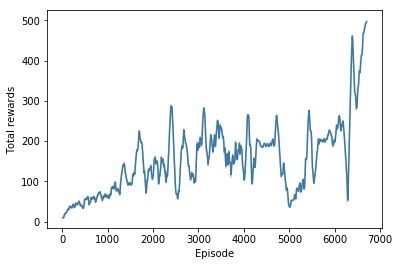

In [32]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0,0.5,'Total rewards')

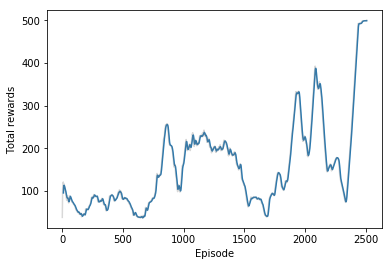

In [29]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0,0.5,'Total rewards')

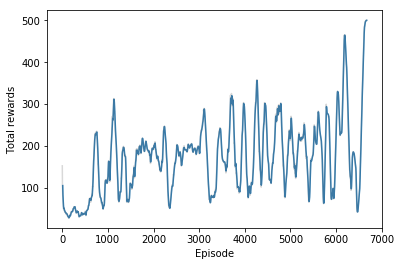

In [33]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0,0.5,'Total rewards')

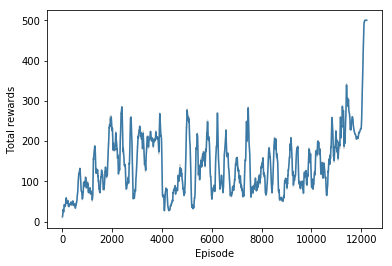

In [30]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0,0.5,'Total rewards')

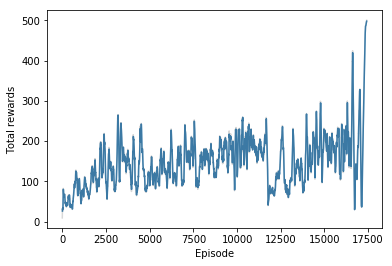

In [113]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0,0.5,'Total rewards')

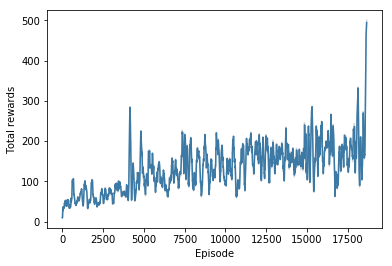

In [111]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0,0.5,'Total rewards')

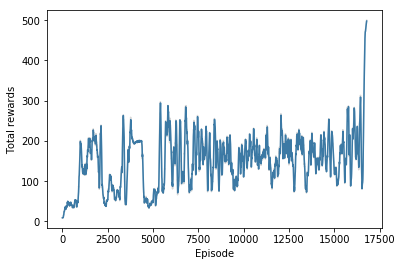

In [108]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0,0.5,'Total rewards')

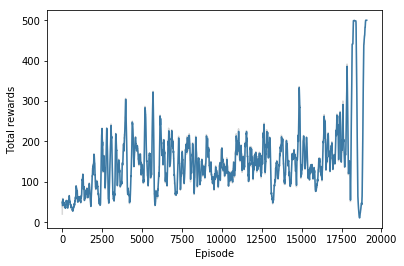

In [105]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0,0.5,'Total rewards')

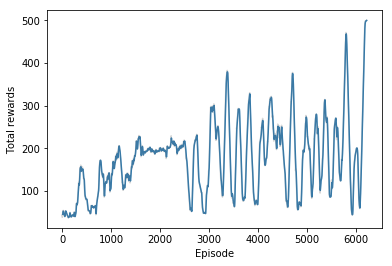

In [102]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0,0.5,'Total rewards')

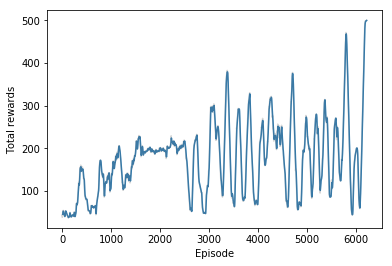

In [101]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0,0.5,'Total rewards')

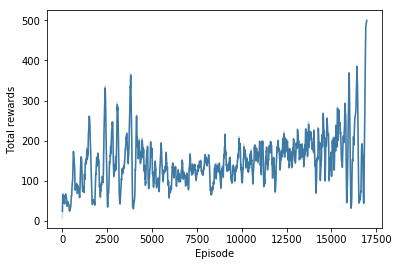

In [95]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0,0.5,'Total rewards')

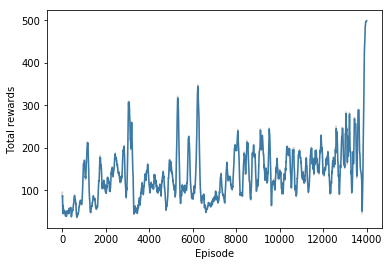

In [72]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0,0.5,'Total rewards')

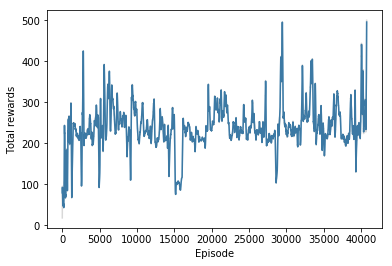

In [54]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0,0.5,'Total rewards')

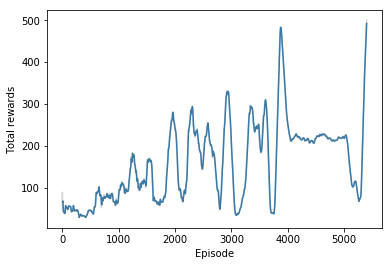

In [27]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0,0.5,'Total rewards')

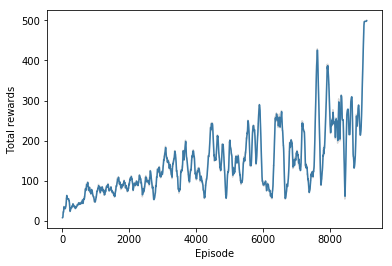

In [29]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0,0.5,'Total rewards')

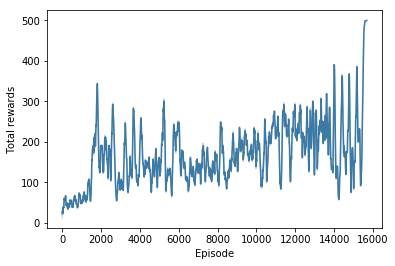

In [46]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0,0.5,'Total rewards')

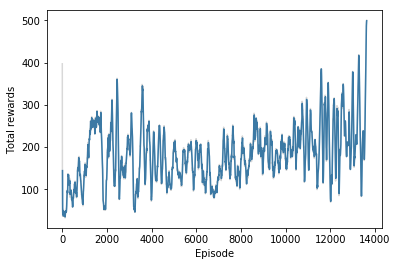

In [32]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

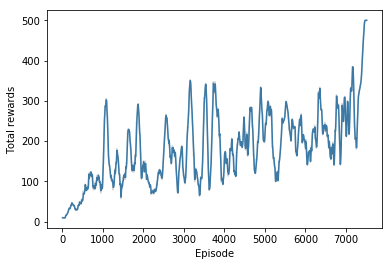

Text(0,0.5,'G losses')

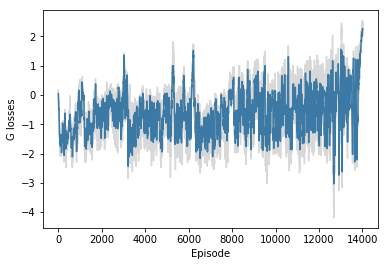

In [73]:
eps, arr = np.array(g_loss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('G losses')

Text(0,0.5,'G losses')

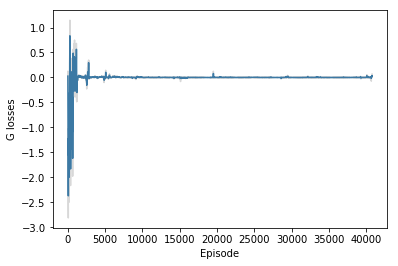

In [55]:
eps, arr = np.array(g_loss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('G losses')

Text(0,0.5,'G losses')

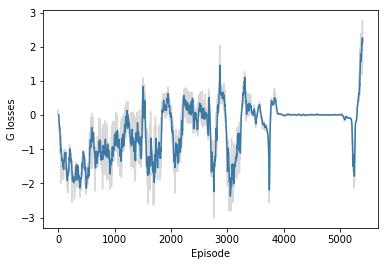

In [28]:
eps, arr = np.array(g_loss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('G losses')

Text(0,0.5,'G losses')

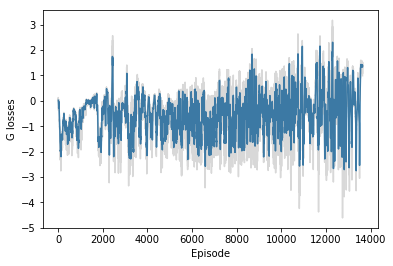

In [33]:
eps, arr = np.array(g_loss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('G losses')

Text(0,0.5,'G losses')

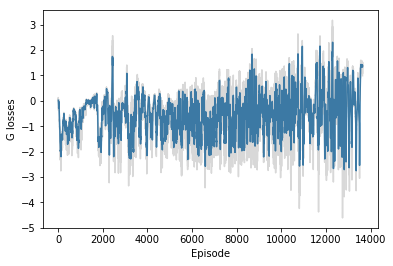

In [30]:
eps, arr = np.array(g_loss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('G losses')

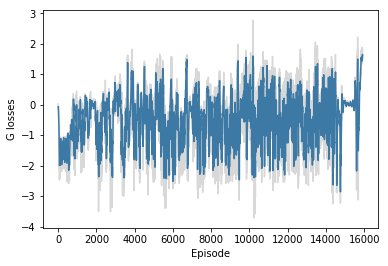
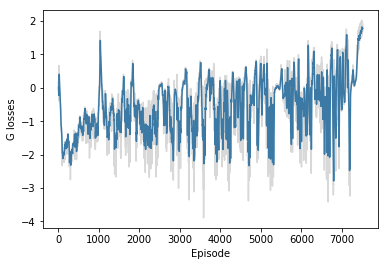

Text(0,0.5,'D losses')

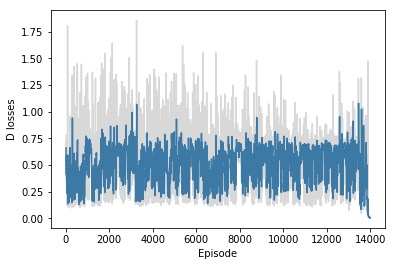

In [74]:
eps, arr = np.array(d_loss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('D losses')

Text(0,0.5,'D losses')

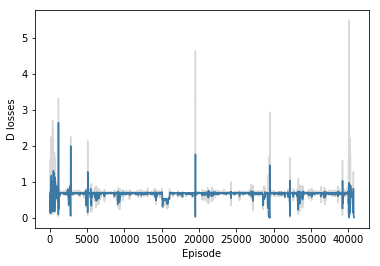

In [56]:
eps, arr = np.array(d_loss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('D losses')

Text(0,0.5,'D losses')

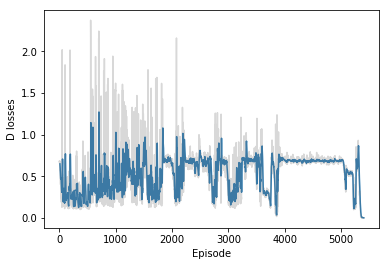

In [29]:
eps, arr = np.array(d_loss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('D losses')

Text(0,0.5,'D losses')

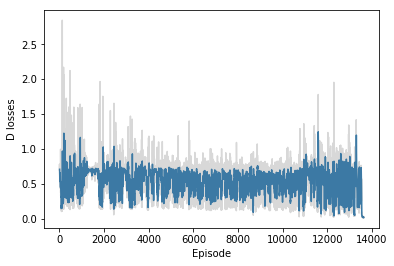

In [34]:
eps, arr = np.array(d_loss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('D losses')

Text(0,0.5,'D losses')

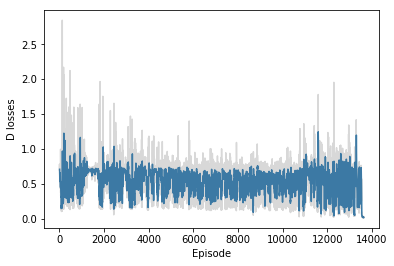

In [31]:
eps, arr = np.array(d_loss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('D losses')

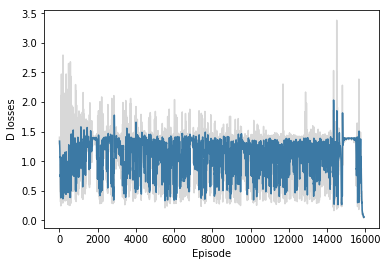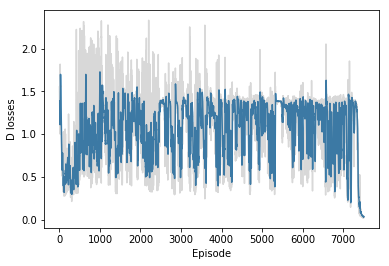

Text(0,0.5,'D losses R')

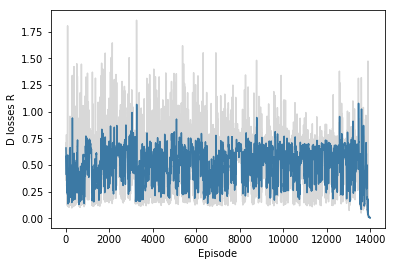

In [75]:
eps, arr = np.array(d_lossR_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('D losses R')

Text(0,0.5,'D losses R')

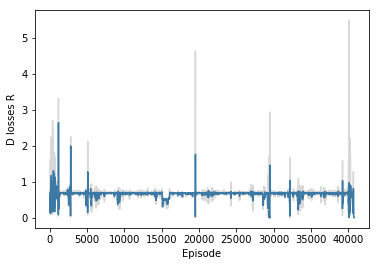

In [57]:
eps, arr = np.array(d_lossR_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('D losses R')

Text(0,0.5,'D losses R')

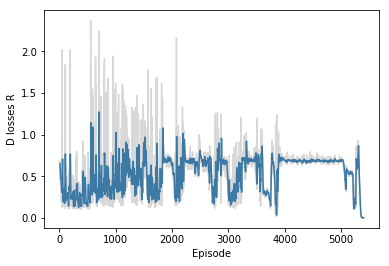

In [31]:
eps, arr = np.array(d_lossR_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('D losses R')

Text(0,0.5,'D losses R')

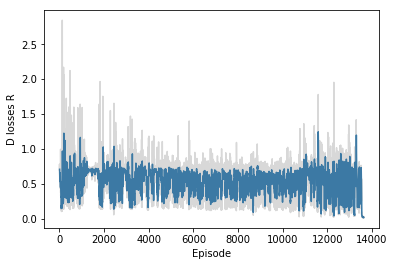

In [35]:
eps, arr = np.array(d_lossR_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('D losses R')

Text(0,0.5,'D losses R')

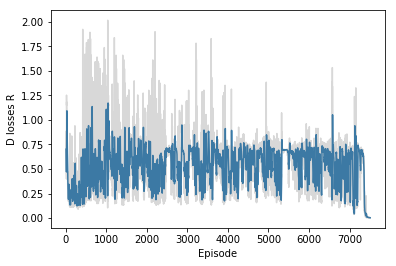

In [32]:
eps, arr = np.array(d_lossR_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('D losses R')

Text(0,0.5,'D losses Q')

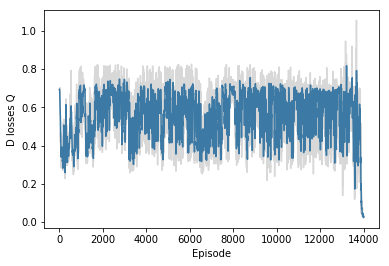

In [76]:
eps, arr = np.array(d_lossQ_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('D losses Q')

Text(0,0.5,'D losses Q')

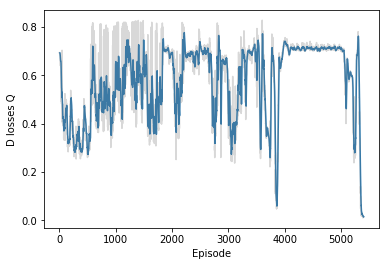

In [32]:
eps, arr = np.array(d_lossQ_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('D losses Q')

Text(0,0.5,'D losses Q')

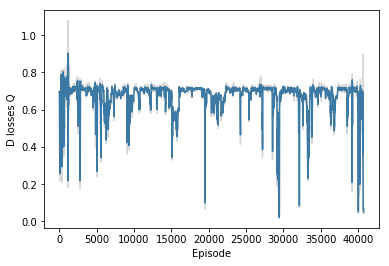

In [58]:
eps, arr = np.array(d_lossQ_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('D losses Q')

Text(0,0.5,'D losses Q')

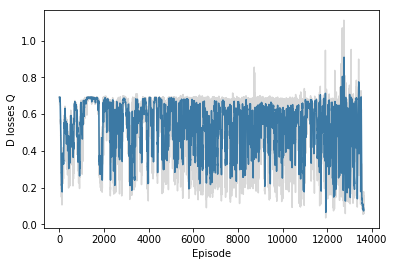

In [36]:
eps, arr = np.array(d_lossQ_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('D losses Q')

Text(0,0.5,'D losses Q')

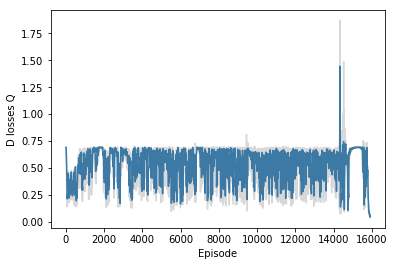

In [33]:
eps, arr = np.array(d_lossQ_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('D losses Q')

Text(0,0.5,'D losses Q')

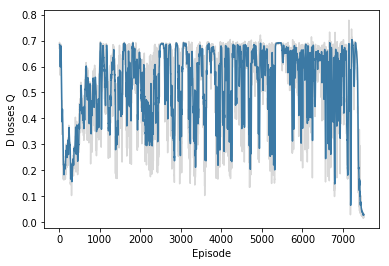

In [33]:
eps, arr = np.array(d_lossQ_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('D losses Q')

## Testing

Let's checkout how our trained agent plays the game.

In [34]:
import gym
env = gym.make('CartPole-v0')
env = gym.make('CartPole-v1')
# env = gym.make('Acrobot-v1')
# env = gym.make('MountainCar-v0')
# env = gym.make('Pendulum-v0')
# env = gym.make('Blackjack-v0')
# env = gym.make('FrozenLake-v0')
# env = gym.make('AirRaid-ram-v0')
# env = gym.make('AirRaid-v0')
# env = gym.make('BipedalWalker-v2')
# env = gym.make('Copy-v0')
# env = gym.make('CarRacing-v0')
# env = gym.make('Ant-v2') #mujoco
# env = gym.make('FetchPickAndPlace-v1') # mujoco required!

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    #saver.restore(sess, 'checkpoints/model.ckpt')    
    saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    
    # Episodes/epochs
    for _ in range(100):
    #while True:
        state = env.reset()
        total_reward = 0

        # Steps/batches
        #for _ in range(111111111111111111):
        while True:
            env.render()
            action_logits = sess.run(model.actions_logits, feed_dict={model.states: np.reshape(state, [1, -1])})
            action = np.argmax(action_logits)
            state, reward, done, _ = env.step(action)
            total_reward += reward
            if done:
                break
        # Print and break condition
        print('total_reward: {}'.format(total_reward))
        # if total_reward == 500:
        #     break
                
# Closing the env
env.close()

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
INFO:tensorflow:Restoring parameters from checkpoints/model.ckpt


/home/arasdar/anaconda3/envs/env/lib/python3.6/site-packages/gym/__init__.py:22: UserWarning: DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.
  warnings.warn('DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.')


total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0


## Extending this

So, Cart-Pole is a pretty simple game. However, the same model can be used to train an agent to play something much more complicated like Pong or Space Invaders. Instead of a state like we're using here though, you'd want to use convolutional layers to get the state from the screen images.

![Deep Q-Learning Atari](assets/atari-network.png)

I'll leave it as a challenge for you to use deep Q-learning to train an agent to play Atari games. Here's the original paper which will get you started: http://www.davidqiu.com:8888/research/nature14236.pdf.